<a href="https://colab.research.google.com/github/christophergaughan/GNN-Antibiotics/blob/main/GNN_Antibiotics_v2_Rigorous_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNN-Guided Antibiotic Discovery: A Rigorous Computational Pipeline

## Targeting DNA Gyrase Subunit B (GyrB) with Uncertainty-Aware Graph Attention Networks

**Author:** Christopher L. Gaughan, Ph.D.  
**Date:** January 2026  
**Target:** CHEMBL240 (DNA Gyrase Subunit B, *E. coli*)

---

## 1. Introduction

This notebook implements a scientifically rigorous pipeline for GNN-guided antibiotic discovery. Unlike typical ML demonstrations that prioritize metrics on random splits, this work emphasizes **generalization to novel chemistry**, **uncertainty quantification**, and **multi-modal validation**.

### 1.1 Why GyrB?

DNA gyrase is a validated antibacterial target with decades of clinical precedent (fluoroquinolones). GyrB, the ATPase subunit, offers a distinct binding site from the fluoroquinolone-targeted GyrA, presenting opportunities for:

- **Overcoming fluoroquinolone resistance**: GyrB inhibitors (e.g., novobiocin, clorobiocin) act via a different mechanism than ciprofloxacin-class drugs
- **Novel mechanism of action**: ATP-competitive inhibition vs. DNA cleavage complex stabilization
- **Reduced cross-resistance**: Mutations conferring fluoroquinolone resistance don't necessarily affect GyrB inhibitor binding

### 1.2 What Makes This Approach Different

| Common Practice | This Pipeline |
|-----------------|---------------|
| Random train/test splits | **Scaffold splits** (Murcko decomposition) to test generalization to novel chemotypes |
| Single model, point estimates | **Ensemble of 5 GATs** with uncertainty quantification |
| Black-box predictions | **Attention-based interpretability** validated against known SAR |
| Activity prediction only | **Multi-objective profiling**: ADMET, selectivity, synthetic accessibility |
| ML metrics in isolation | **Orthogonal validation**: docking into GyrB crystal structure |

### 1.3 Pipeline Overview

```
ChEMBL GyrB IC50 Data
        ↓
Scaffold-Based Splitting (honest generalization estimate)
        ↓
GAT Ensemble Training (uncertainty-aware predictions)
        ↓
Molecular Generation + Filtering (validity, drug-likeness, novelty)
        ↓
Multi-Objective Profiling (ADMET, selectivity, SAScore)
        ↓
Structural Validation (docking + attention/SAR concordance)
        ↓
Pareto-Ranked Candidates with Full Mechanistic Rationale
```

### 1.4 Key Outputs

1. **Honest performance metrics** on scaffold-split test set (alongside random split for comparison)
2. **Novel candidate molecules** with predicted activity ± confidence intervals
3. **Mechanistic interpretation** via attention weight visualization
4. **ADMET and selectivity profiles** for risk assessment
5. **Docking validation** against GyrB crystal structure (PDB: 4DUH)
6. **Convergent evidence map**: ML prediction ↔ attention weights ↔ docking contacts ↔ literature SAR

---

## 1.5 Prior Work: Level 1 Proof of Concept

This notebook builds upon a Level 1 prototype (`GNN_Generation_of_new_antibiotics.ipynb`) that established the foundational pipeline:

### What Level 1 Accomplished

- **Data retrieval**: Paginated ChEMBL query for GyrB (CHEMBL240) IC50 values
- **Graph representation**: SMILES → PyTorch Geometric `Data` objects with 6 atomic features (atomic number, degree, formal charge, hybridization, aromaticity, H-count)
- **Model architecture**: 3-layer GCN with BatchNorm, dropout, global mean pooling
- **Training**: 100 epochs, Adam optimizer, BCE loss with logits
- **Results**: 0.81 validation AUC, 0.75 test AUC, 76% accuracy on random split
- **Generation**: Molecular perturbation (halogen swaps, methyl modifications) on top actives
- **Filtering**: Lipinski Rule of Five, RDKit validity checks

### Level 1 Limitations (Addressed Here)

| Level 1 Limitation | Version 2 Solution |
|-------------------|--------------------|
| Random split overestimates real-world performance | Scaffold split with Murcko decomposition |
| Single model provides no confidence estimate | 5-model ensemble with mean ± std |
| GCN treats all neighbors equally | GAT learns attention over neighbors |
| No interpretability | Attention weight extraction and visualization |
| SMILES string manipulation can break chemistry | Proper valence checking, sanitization |
| No synthetic accessibility filter | SAScore integration |
| No novelty verification | ChEMBL/PubChem duplicate checking |
| Activity prediction in isolation | ADMET, selectivity, docking validation |

### The Core Question

Level 1 answered: *"Can we build a working GNN pipeline for antibiotic discovery?"*

Version 2 answers: *"Can we do it rigorously enough that a medicinal chemist would trust the output?"*

---

## 2. Computational Environment

This notebook is designed for **Google Colab with A100 GPU** (High-RAM runtime).

### 2.1 Hardware Requirements

- **GPU**: A100 recommended (40GB VRAM allows larger batch sizes, ensemble training)
- **RAM**: High-RAM runtime recommended for docking and large molecule processing
- **Storage**: Google Drive mounted for persistent storage of models and results

### 2.2 Dependencies

| Package | Purpose |
|---------|--------|
| `torch`, `torch-geometric` | Graph neural networks |
| `rdkit` | Cheminformatics, molecular manipulation, SAScore |
| `chembl-webresource-client` | Data retrieval |
| `scikit-learn` | Splitting, metrics, preprocessing |
| `deepchem` | Scaffold splitting, ADMET prediction |
| `meeko`, `vina` | Docking preparation and execution |
| `py3Dmol` | 3D molecular visualization |
| `matplotlib`, `seaborn` | Plotting |

### 2.3 Reproducibility

All random seeds are fixed. Model checkpoints and generated candidates are saved to Drive with timestamps.

In [7]:
# =============================================================================
# Cell 1: Mount Google Drive
# =============================================================================

from google.colab import drive
drive.mount('/content/drive')

# Create project directory structure
import os

PROJECT_DIR = '/content/drive/MyDrive/GNN_antibiotics/v2_rigorous'
DIRS = {
    'root': PROJECT_DIR,
    'models': f'{PROJECT_DIR}/models',
    'data': f'{PROJECT_DIR}/data',
    'figures': f'{PROJECT_DIR}/figures',
    'candidates': f'{PROJECT_DIR}/candidates',
    'docking': f'{PROJECT_DIR}/docking'
}

for dir_name, dir_path in DIRS.items():
    os.makedirs(dir_path, exist_ok=True)
    print(f"✓ {dir_name}: {dir_path}")

print(f"\n📁 Project directory initialized: {PROJECT_DIR}")

Mounted at /content/drive
✓ root: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous
✓ models: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/models
✓ data: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/data
✓ figures: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/figures
✓ candidates: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/candidates
✓ docking: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/docking

📁 Project directory initialized: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous


In [8]:
# =============================================================================
# Cell 2: Install Dependencies
# =============================================================================
# This cell installs all required packages. Run once per session.

%%capture install_output

# PyTorch Geometric (compatible with Colab's PyTorch version)
!pip install torch-geometric

# Cheminformatics
!pip install rdkit-pypi
!pip install chembl-webresource-client

# DeepChem for scaffold splitting and ADMET
!pip install deepchem

# Docking tools
!pip install meeko
!pip install vina

# 3D visualization
!pip install py3Dmol

# Additional utilities
!pip install pubchempy  # For novelty checking
!pip install tqdm

print("✓ All packages installed")

In [9]:
# =============================================================================
# Cell 2: Install Dependencies (run this and WAIT for completion)
# =============================================================================

!pip install torch-geometric
!pip install rdkit
!pip install chembl-webresource-client
!pip install deepchem
!pip install meeko
!pip install vina
!pip install py3Dmol
!pip install pubchempy
!pip install tqdm

print("\n" + "="*50)
print("✓ All packages installed - now run Cell 3")
print("="*50)


✓ All packages installed - now run Cell 3


In [10]:
# =============================================================================
# Cell 3: Imports and Configuration
# =============================================================================

import os
import random
import warnings
from datetime import datetime
from typing import List, Dict, Tuple, Optional
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# PyTorch Geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool, global_add_pool, global_max_pool

# RDKit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Draw, rdMolDescriptors
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import QED
from rdkit.Contrib.SA_Score import sascorer  # Synthetic accessibility

# Sklearn
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, precision_recall_curve,
    average_precision_score
)

# ChEMBL
from chembl_webresource_client.new_client import new_client

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# =============================================================================
# Configuration
# =============================================================================

class Config:
    """Central configuration for reproducibility and easy tuning."""

    # Random seeds
    SEED = 42

    # Data
    TARGET_CHEMBL_ID = 'CHEMBL240'  # DNA Gyrase B
    ACTIVITY_THRESHOLD = 1000  # nM - compounds with IC50 <= this are "active"
    MIN_ATOMS = 5  # Filter out very small molecules
    MAX_ATOMS = 100  # Filter out very large molecules

    # Model
    ATOM_FEATURES = 9  # Expanded feature set
    HIDDEN_DIM = 128
    NUM_GAT_LAYERS = 3
    NUM_ATTENTION_HEADS = 4
    DROPOUT = 0.3

    # Training
    BATCH_SIZE = 64
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5
    EPOCHS = 150
    PATIENCE = 20  # Early stopping

    # Ensemble
    N_ENSEMBLE = 5

    # Generation
    TOP_K_SCAFFOLDS = 50  # Number of top actives to use as starting points
    ACTIVITY_THRESHOLD_GENERATION = 0.7  # Minimum predicted probability
    UNCERTAINTY_THRESHOLD = 0.15  # Maximum acceptable std dev
    SASCORE_THRESHOLD = 4.0  # Maximum synthetic accessibility score
    QED_THRESHOLD = 0.4  # Minimum drug-likeness score

    # Paths
    PROJECT_DIR = '/content/drive/MyDrive/GNN_antibiotics/v2_rigorous'


def set_seed(seed: int = Config.SEED):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Device configuration
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    DEVICE = torch.device('cpu')
    print("⚠️  GPU not available, using CPU")

print(f"\n⚙️  Configuration loaded:")
print(f"   Target: {Config.TARGET_CHEMBL_ID}")
print(f"   Activity threshold: {Config.ACTIVITY_THRESHOLD} nM")
print(f"   Ensemble size: {Config.N_ENSEMBLE}")
print(f"   Seed: {Config.SEED}")

🚀 GPU: NVIDIA A100-SXM4-80GB
   Memory: 85.2 GB

⚙️  Configuration loaded:
   Target: CHEMBL240
   Activity threshold: 1000 nM
   Ensemble size: 5
   Seed: 42


---

## 3. Data Retrieval and Preprocessing

### 3.1 ChEMBL Query Strategy

We query ChEMBL for all IC50 measurements against DNA Gyrase Subunit B (CHEMBL240). Key considerations:

1. **Pagination**: ChEMBL API can timeout on large queries; we fetch in batches of 1000
2. **Deduplication**: Multiple assays may report the same compound; we keep the lowest (most potent) IC50
3. **Unit standardization**: All values converted to nM
4. **Quality filtering**: Remove entries with missing SMILES or invalid IC50 values

In [24]:
# =============================================================================
# Cell 4: Data Retrieval from ChEMBL
# =============================================================================

def fetch_chembl_data(target_id: str, limit_per_batch: int = 1000, max_records: int = 15000) -> pd.DataFrame:
    """
    Fetch IC50 activity data from ChEMBL with pagination.

    Args:
        target_id: ChEMBL target ID (e.g., 'CHEMBL240')
        limit_per_batch: Records per API call
        max_records: Safety cap on total records

    Returns:
        DataFrame with molecule_chembl_id, canonical_smiles, standard_value
    """
    chembl = new_client.activity
    all_activities = []
    offset = 0

    print(f"📥 Fetching data for {target_id}...")

    with tqdm(total=max_records, desc="Records fetched") as pbar:
        while offset < max_records:
            batch = chembl.filter(
                target_chembl_id=target_id,
                standard_type='IC50'
            ).only(
                'molecule_chembl_id',
                'canonical_smiles',
                'standard_value',
                'standard_units',
                'assay_chembl_id',
                'pchembl_value'
            )[offset:offset + limit_per_batch]

            batch_list = list(batch)

            if not batch_list:
                break

            all_activities.extend(batch_list)
            pbar.update(len(batch_list))
            offset += limit_per_batch

    df = pd.DataFrame(all_activities)
    print(f"\n✓ Retrieved {len(df)} raw activity records")

    return df


# Fetch data
raw_data = fetch_chembl_data(Config.TARGET_CHEMBL_ID)

📥 Fetching data for CHEMBL240...


Records fetched:   0%|          | 0/15000 [00:00<?, ?it/s]


✓ Retrieved 1280 raw activity records


In [25]:
# =============================================================================
# Cell 5: Data Cleaning and Preprocessing
# =============================================================================

def clean_activity_data(df: pd.DataFrame, activity_threshold: float = Config.ACTIVITY_THRESHOLD) -> pd.DataFrame:
    """
    Clean and preprocess activity data.

    Steps:
    1. Remove missing values
    2. Standardize units to nM
    3. Remove duplicate SMILES (keep most potent)
    4. Validate SMILES with RDKit
    5. Filter by molecule size
    6. Create binary activity labels
    """
    print("🧹 Cleaning data...")

    # Copy to avoid modifying original
    df = df.copy()
    initial_count = len(df)

    # Step 1: Remove missing values
    df = df.dropna(subset=['canonical_smiles', 'standard_value'])
    print(f"   After dropping NaN: {len(df)} ({initial_count - len(df)} removed)")

    # Step 2: Convert to numeric and filter valid IC50
    df['standard_value'] = pd.to_numeric(df['standard_value'], errors='coerce')
    df = df.dropna(subset=['standard_value'])
    df = df[df['standard_value'] > 0]  # IC50 must be positive
    print(f"   After numeric conversion: {len(df)}")

    # Step 3: Deduplicate - keep lowest IC50 per SMILES
    df = df.sort_values('standard_value').drop_duplicates(subset='canonical_smiles', keep='first')
    print(f"   After deduplication: {len(df)}")

    # Step 4: Validate SMILES and compute properties
    valid_rows = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="   Validating SMILES"):
        mol = Chem.MolFromSmiles(row['canonical_smiles'])
        if mol is not None:
            num_atoms = mol.GetNumAtoms()
            if Config.MIN_ATOMS <= num_atoms <= Config.MAX_ATOMS:
                row['num_atoms'] = num_atoms
                row['mol_weight'] = Descriptors.MolWt(mol)
                valid_rows.append(row)

    df = pd.DataFrame(valid_rows)
    print(f"   After validation: {len(df)}")

    # Step 5: Create binary labels
    df['active'] = (df['standard_value'] <= activity_threshold).astype(int)

    # Step 6: Add pIC50 (more useful for ML)
    df['pIC50'] = -np.log10(df['standard_value'] * 1e-9)  # Convert nM to M, then -log10

    print(f"\n✓ Final dataset: {len(df)} compounds")
    print(f"   Active (IC50 ≤ {activity_threshold} nM): {df['active'].sum()} ({100*df['active'].mean():.1f}%)")
    print(f"   Inactive: {(df['active'] == 0).sum()} ({100*(1-df['active'].mean()):.1f}%)")

    return df.reset_index(drop=True)


# Clean data
clean_data = clean_activity_data(raw_data)

# Quick sanity check
print(f"\n📊 IC50 Distribution:")
print(f"   Min: {clean_data['standard_value'].min():.2f} nM")
print(f"   Max: {clean_data['standard_value'].max():.2f} nM")
print(f"   Median: {clean_data['standard_value'].median():.2f} nM")

🧹 Cleaning data...
   After dropping NaN: 1203 (77 removed)
   After numeric conversion: 1203
   After deduplication: 1000


   Validating SMILES:   0%|          | 0/1000 [00:00<?, ?it/s]

   After validation: 1000

✓ Final dataset: 1000 compounds
   Active (IC50 ≤ 1000 nM): 232 (23.2%)
   Inactive: 768 (76.8%)

📊 IC50 Distribution:
   Min: 0.90 nM
   Max: 954992586.02 nM
   Median: 6309.57 nM


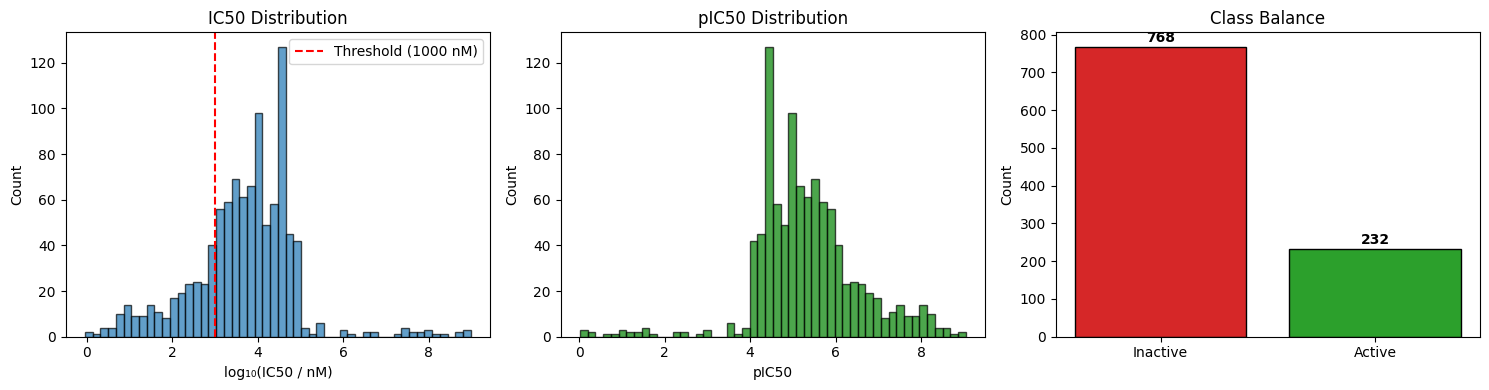


✓ Figure saved to /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/figures/data_distribution.png


In [26]:
# =============================================================================
# Cell 6: Visualize Data Distribution
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# IC50 distribution (log scale)
axes[0].hist(np.log10(clean_data['standard_value']), bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=np.log10(Config.ACTIVITY_THRESHOLD), color='red', linestyle='--',
                label=f'Threshold ({Config.ACTIVITY_THRESHOLD} nM)')
axes[0].set_xlabel('log₁₀(IC50 / nM)')
axes[0].set_ylabel('Count')
axes[0].set_title('IC50 Distribution')
axes[0].legend()

# pIC50 distribution
axes[1].hist(clean_data['pIC50'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('pIC50')
axes[1].set_ylabel('Count')
axes[1].set_title('pIC50 Distribution')

# Class balance
class_counts = clean_data['active'].value_counts().sort_index()
bars = axes[2].bar(['Inactive', 'Active'], class_counts.values,
                   color=['#d62728', '#2ca02c'], edgecolor='black')
axes[2].set_ylabel('Count')
axes[2].set_title('Class Balance')
for bar, count in zip(bars, class_counts.values):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f"{DIRS['figures']}/data_distribution.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved to {DIRS['figures']}/data_distribution.png")

---

## 4. Scaffold-Based Data Splitting

### 4.1 Why Scaffold Splits?

Random splits allow structurally similar molecules to appear in both training and test sets. This **inflates performance metrics** because the model can memorize local structure-activity relationships rather than learning generalizable patterns.

**Scaffold splitting** (using Murcko decomposition) ensures that:
- Training and test sets contain **completely different molecular scaffolds**
- The model must generalize to **novel chemotypes**
- Performance reflects **real-world utility** for drug discovery

### 4.2 Murcko Scaffolds

The Murcko scaffold is the core ring system of a molecule with all side chains removed. For example:
- Ciprofloxacin → fluoroquinolone core
- Novobiocin → aminocoumarin core

By splitting on scaffolds, we ask: *"Can the model predict activity for entirely new chemical classes?"*

In [27]:
# =============================================================================
# Cell 7: Compute Murcko Scaffolds
# =============================================================================

def get_murcko_scaffold(smiles: str) -> str:
    """
    Extract Murcko scaffold from SMILES.
    Returns generic scaffold (no side chains, no atom types on chains).
    """
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    except:
        return None


# Compute scaffolds for all molecules
print("🔬 Computing Murcko scaffolds...")
clean_data['scaffold'] = clean_data['canonical_smiles'].apply(get_murcko_scaffold)

# Remove any that failed
clean_data = clean_data.dropna(subset=['scaffold']).reset_index(drop=True)

# Scaffold statistics
n_scaffolds = clean_data['scaffold'].nunique()
scaffold_counts = clean_data['scaffold'].value_counts()

print(f"\n✓ Scaffold analysis:")
print(f"   Unique scaffolds: {n_scaffolds}")
print(f"   Compounds per scaffold: {scaffold_counts.mean():.1f} (mean), {scaffold_counts.median():.0f} (median)")
print(f"   Largest scaffold cluster: {scaffold_counts.max()} compounds")
print(f"   Singletons (1 compound): {(scaffold_counts == 1).sum()}")

🔬 Computing Murcko scaffolds...

✓ Scaffold analysis:
   Unique scaffolds: 541
   Compounds per scaffold: 1.8 (mean), 1 (median)
   Largest scaffold cluster: 24 compounds
   Singletons (1 compound): 376


In [28]:
# =============================================================================
# Cell 8: Scaffold-Based Train/Val/Test Split
# =============================================================================

def scaffold_split(df: pd.DataFrame, train_frac: float = 0.8, val_frac: float = 0.1,
                   seed: int = Config.SEED) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Split data by scaffold to ensure no scaffold overlap between sets.

    Strategy:
    1. Group compounds by scaffold
    2. Sort scaffolds by size (largest first) for reproducibility
    3. Assign entire scaffold groups to train/val/test
    """
    np.random.seed(seed)

    # Group by scaffold
    scaffold_groups = df.groupby('scaffold').indices
    scaffolds = list(scaffold_groups.keys())

    # Shuffle scaffolds
    np.random.shuffle(scaffolds)

    # Calculate split sizes
    n_total = len(df)
    n_train = int(n_total * train_frac)
    n_val = int(n_total * val_frac)

    train_idx, val_idx, test_idx = [], [], []

    for scaffold in scaffolds:
        indices = scaffold_groups[scaffold].tolist()

        if len(train_idx) < n_train:
            train_idx.extend(indices)
        elif len(val_idx) < n_val:
            val_idx.extend(indices)
        else:
            test_idx.extend(indices)

    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)
    test_df = df.iloc[test_idx].reset_index(drop=True)

    return train_df, val_df, test_df


def random_split(df: pd.DataFrame, train_frac: float = 0.8, val_frac: float = 0.1,
                 seed: int = Config.SEED) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Standard random split for comparison.
    """
    np.random.seed(seed)

    n = len(df)
    indices = np.random.permutation(n)

    n_train = int(n * train_frac)
    n_val = int(n * val_frac)

    train_df = df.iloc[indices[:n_train]].reset_index(drop=True)
    val_df = df.iloc[indices[n_train:n_train+n_val]].reset_index(drop=True)
    test_df = df.iloc[indices[n_train+n_val:]].reset_index(drop=True)

    return train_df, val_df, test_df


# Create both splits
print("📊 Creating data splits...\n")

# Scaffold split (primary)
train_scaffold, val_scaffold, test_scaffold = scaffold_split(clean_data)

# Random split (for comparison)
train_random, val_random, test_random = random_split(clean_data)

# Report
print("SCAFFOLD SPLIT (Primary - Honest Metrics):")
print(f"  Train: {len(train_scaffold)} compounds, {train_scaffold['scaffold'].nunique()} scaffolds, {train_scaffold['active'].sum()} active ({100*train_scaffold['active'].mean():.1f}%)")
print(f"  Val:   {len(val_scaffold)} compounds, {val_scaffold['scaffold'].nunique()} scaffolds, {val_scaffold['active'].sum()} active ({100*val_scaffold['active'].mean():.1f}%)")
print(f"  Test:  {len(test_scaffold)} compounds, {test_scaffold['scaffold'].nunique()} scaffolds, {test_scaffold['active'].sum()} active ({100*test_scaffold['active'].mean():.1f}%)")

# Verify no scaffold leakage
train_scaffolds = set(train_scaffold['scaffold'].unique())
val_scaffolds = set(val_scaffold['scaffold'].unique())
test_scaffolds = set(test_scaffold['scaffold'].unique())

assert len(train_scaffolds & val_scaffolds) == 0, "Scaffold leakage: train-val!"
assert len(train_scaffolds & test_scaffolds) == 0, "Scaffold leakage: train-test!"
assert len(val_scaffolds & test_scaffolds) == 0, "Scaffold leakage: val-test!"
print("  ✓ No scaffold leakage between sets\n")

print("RANDOM SPLIT (For Comparison Only):")
print(f"  Train: {len(train_random)} compounds, {train_random['active'].sum()} active ({100*train_random['active'].mean():.1f}%)")
print(f"  Val:   {len(val_random)} compounds, {val_random['active'].sum()} active ({100*val_random['active'].mean():.1f}%)")
print(f"  Test:  {len(test_random)} compounds, {test_random['active'].sum()} active ({100*test_random['active'].mean():.1f}%)")

# Save splits
train_scaffold.to_csv(f"{DIRS['data']}/train_scaffold.csv", index=False)
val_scaffold.to_csv(f"{DIRS['data']}/val_scaffold.csv", index=False)
test_scaffold.to_csv(f"{DIRS['data']}/test_scaffold.csv", index=False)
print(f"\n✓ Splits saved to {DIRS['data']}")

📊 Creating data splits...

SCAFFOLD SPLIT (Primary - Honest Metrics):
  Train: 800 compounds, 433 scaffolds, 177 active (22.1%)
  Val:   102 compounds, 44 scaffolds, 38 active (37.3%)
  Test:  98 compounds, 64 scaffolds, 17 active (17.3%)
  ✓ No scaffold leakage between sets

RANDOM SPLIT (For Comparison Only):
  Train: 800 compounds, 183 active (22.9%)
  Val:   100 compounds, 25 active (25.0%)
  Test:  100 compounds, 24 active (24.0%)

✓ Splits saved to /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/data


---

## 5. Molecular Graph Representation

### 5.1 Node Features (Atoms)

We use an expanded 9-dimensional feature vector for each atom:

| Feature | Description | Encoding |
|---------|-------------|----------|
| Atomic number | Element type | Integer |
| Degree | Number of bonded neighbors | Integer |
| Formal charge | Ionic state | Integer |
| Hybridization | sp, sp2, sp3, etc. | Integer (enum) |
| Aromaticity | Is aromatic? | Binary |
| Total Hs | Implicit + explicit H count | Integer |
| In ring | Part of any ring? | Binary |
| Ring size | Size of smallest ring (0 if not in ring) | Integer |
| Chirality | R, S, or none | Integer (enum) |

### 5.2 Edge Features (Bonds)

We include bond features for more expressive message passing:

| Feature | Description |
|---------|-------------|
| Bond type | Single, double, triple, aromatic |
| Conjugated | Is part of conjugated system? |
| In ring | Is part of ring? |

In [29]:
# =============================================================================
# Cell 9: Molecule to Graph Conversion
# =============================================================================

def mol_to_graph(smiles: str, label: float) -> Optional[Data]:
    """
    Convert SMILES to PyTorch Geometric Data object with rich features.

    Args:
        smiles: SMILES string
        label: Activity label (0 or 1 for classification, or continuous for regression)

    Returns:
        PyTorch Geometric Data object or None if conversion fails
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Compute ring info
    ring_info = mol.GetRingInfo()

    # Node features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()

        # Ring features
        in_ring = ring_info.NumAtomRings(atom_idx) > 0
        ring_sizes = [len(ring) for ring in ring_info.AtomRings() if atom_idx in ring]
        min_ring_size = min(ring_sizes) if ring_sizes else 0

        # Chirality
        chiral_tag = int(atom.GetChiralTag())

        features = [
            atom.GetAtomicNum(),              # 0: Atomic number
            atom.GetDegree(),                 # 1: Degree
            atom.GetFormalCharge(),           # 2: Formal charge
            int(atom.GetHybridization()),     # 3: Hybridization
            int(atom.GetIsAromatic()),        # 4: Aromaticity
            atom.GetTotalNumHs(),             # 5: Total H count
            int(in_ring),                     # 6: In ring
            min_ring_size,                    # 7: Smallest ring size
            chiral_tag,                       # 8: Chirality
        ]
        atom_features.append(features)

    x = torch.tensor(atom_features, dtype=torch.float)

    # Edge index and edge features
    edge_index = []
    edge_attr = []

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        # Bond features
        bond_type = int(bond.GetBondType())  # 1=single, 2=double, 3=triple, 12=aromatic
        conjugated = int(bond.GetIsConjugated())
        in_ring = int(bond.IsInRing())

        bond_features = [bond_type, conjugated, in_ring]

        # Add both directions (undirected graph)
        edge_index.append([i, j])
        edge_index.append([j, i])
        edge_attr.append(bond_features)
        edge_attr.append(bond_features)

    if len(edge_index) == 0:
        # Single atom - add self-loop
        edge_index = [[0, 0]]
        edge_attr = [[0, 0, 0]]

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)

    y = torch.tensor([label], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, smiles=smiles)


def df_to_graphs(df: pd.DataFrame, label_col: str = 'active') -> List[Data]:
    """Convert DataFrame to list of graph objects."""
    graphs = []
    failed = 0

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Converting to graphs"):
        graph = mol_to_graph(row['canonical_smiles'], row[label_col])
        if graph is not None:
            graphs.append(graph)
        else:
            failed += 1

    print(f"   ✓ Converted {len(graphs)} molecules, {failed} failed")
    return graphs


# Convert all splits to graphs
print("🔄 Converting molecules to graphs...\n")

print("Scaffold split:")
train_graphs_scaffold = df_to_graphs(train_scaffold)
val_graphs_scaffold = df_to_graphs(val_scaffold)
test_graphs_scaffold = df_to_graphs(test_scaffold)

print("\nRandom split:")
train_graphs_random = df_to_graphs(train_random)
val_graphs_random = df_to_graphs(val_random)
test_graphs_random = df_to_graphs(test_random)

# Sample graph info
sample = train_graphs_scaffold[0]
print(f"\n📊 Sample graph:")
print(f"   Nodes: {sample.x.shape[0]}")
print(f"   Node features: {sample.x.shape[1]}")
print(f"   Edges: {sample.edge_index.shape[1]}")
print(f"   Edge features: {sample.edge_attr.shape[1]}")

🔄 Converting molecules to graphs...

Scaffold split:


Converting to graphs:   0%|          | 0/800 [00:00<?, ?it/s]

   ✓ Converted 800 molecules, 0 failed


Converting to graphs:   0%|          | 0/102 [00:00<?, ?it/s]

   ✓ Converted 102 molecules, 0 failed


Converting to graphs:   0%|          | 0/98 [00:00<?, ?it/s]

   ✓ Converted 98 molecules, 0 failed

Random split:


Converting to graphs:   0%|          | 0/800 [00:00<?, ?it/s]

   ✓ Converted 800 molecules, 0 failed


Converting to graphs:   0%|          | 0/100 [00:00<?, ?it/s]

   ✓ Converted 100 molecules, 0 failed


Converting to graphs:   0%|          | 0/100 [00:00<?, ?it/s]

   ✓ Converted 100 molecules, 0 failed

📊 Sample graph:
   Nodes: 16
   Node features: 9
   Edges: 32
   Edge features: 3


In [30]:
# =============================================================================
# Cell 10: Create DataLoaders
# =============================================================================

# Scaffold split loaders (primary)
train_loader_scaffold = DataLoader(train_graphs_scaffold, batch_size=Config.BATCH_SIZE, shuffle=True)
val_loader_scaffold = DataLoader(val_graphs_scaffold, batch_size=Config.BATCH_SIZE)
test_loader_scaffold = DataLoader(test_graphs_scaffold, batch_size=Config.BATCH_SIZE)

# Random split loaders (for comparison)
train_loader_random = DataLoader(train_graphs_random, batch_size=Config.BATCH_SIZE, shuffle=True)
val_loader_random = DataLoader(val_graphs_random, batch_size=Config.BATCH_SIZE)
test_loader_random = DataLoader(test_graphs_random, batch_size=Config.BATCH_SIZE)

print("✓ DataLoaders created")
print(f"   Batch size: {Config.BATCH_SIZE}")
print(f"   Train batches (scaffold): {len(train_loader_scaffold)}")
print(f"   Val batches (scaffold): {len(val_loader_scaffold)}")
print(f"   Test batches (scaffold): {len(test_loader_scaffold)}")

✓ DataLoaders created
   Batch size: 64
   Train batches (scaffold): 13
   Val batches (scaffold): 2
   Test batches (scaffold): 2


---

## 6. Graph Attention Network (GAT) Architecture

### 6.1 Why GAT over GCN?

GCN (Graph Convolutional Network) treats all neighbors equally when aggregating information. GAT (Graph Attention Network) learns **attention weights** over neighbors, allowing the model to:

1. **Focus on important atoms**: Not all neighbors contribute equally to activity
2. **Provide interpretability**: Attention weights reveal which substructures drive predictions
3. **Handle diverse chemistry**: Different atom contexts can require different aggregation strategies

### 6.2 Architecture Overview

```
Input: Atom features (N × 9)
    ↓
GAT Layer 1 (4 heads) → BatchNorm → ELU → Dropout
    ↓
GAT Layer 2 (4 heads) → BatchNorm → ELU → Dropout  
    ↓
GAT Layer 3 (4 heads, return attention) → BatchNorm → ELU
    ↓
Global Attention Pooling (learn which atoms matter for molecular property)
    ↓
FC Layer (hidden → hidden/2) → ELU → Dropout
    ↓
Output Layer (hidden/2 → 1) → Sigmoid
```

### 6.3 Attention Extraction

We extract attention weights from the final GAT layer for interpretability. These weights indicate which neighbor atoms the model "attends to" when computing each atom's representation.

In [31]:
# =============================================================================
# Cell 11: GAT Model Definition
# =============================================================================

class GATAntibiotics(nn.Module):
    """
    Graph Attention Network for antibiotic activity prediction.

    Features:
    - Multi-head attention for robust feature learning
    - Residual connections for stable training
    - Attention weight extraction for interpretability
    - Global attention pooling for graph-level predictions
    """

    def __init__(
        self,
        input_dim: int = Config.ATOM_FEATURES,
        hidden_dim: int = Config.HIDDEN_DIM,
        num_layers: int = Config.NUM_GAT_LAYERS,
        num_heads: int = Config.NUM_ATTENTION_HEADS,
        dropout: float = Config.DROPOUT
    ):
        super(GATAntibiotics, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout

        # Initial projection
        self.input_proj = nn.Linear(input_dim, hidden_dim)

        # GAT layers
        self.gat_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for i in range(num_layers):
            # For final layer, we want to return attention weights
            gat = GATConv(
                hidden_dim,
                hidden_dim // num_heads,
                heads=num_heads,
                dropout=dropout,
                concat=True  # Concatenate head outputs
            )
            self.gat_layers.append(gat)
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Global attention pooling
        self.gate_nn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ELU(),
            nn.Linear(hidden_dim // 2, 1)
        )

        # Prediction head
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, 1)

        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, data, return_attention: bool = False):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Initial projection
        x = self.input_proj(x)
        x = F.elu(x)

        # Store attention weights from all layers
        attention_weights = []

        # GAT layers with residual connections
        for i, (gat, bn) in enumerate(zip(self.gat_layers, self.batch_norms)):
            x_residual = x

            # GAT forward with attention weights
            x, (edge_index_out, alpha) = gat(x, edge_index, return_attention_weights=True)

            if return_attention:
                attention_weights.append(alpha)

            x = bn(x)
            x = F.elu(x)

            # Residual connection
            x = x + x_residual

            if i < self.num_layers - 1:
                x = self.dropout_layer(x)

        # Global attention pooling
        gate = torch.sigmoid(self.gate_nn(x))
        x = x * gate
        x = global_add_pool(x, batch)

        # Prediction head
        x = self.fc1(x)
        x = F.elu(x)
        x = self.dropout_layer(x)
        x = self.fc2(x)

        if return_attention:
            return x, attention_weights, gate
        return x


# Test model creation
model_test = GATAntibiotics().to(DEVICE)
n_params = sum(p.numel() for p in model_test.parameters())

print(f"✓ GAT model created")
print(f"   Parameters: {n_params:,}")
print(f"   Hidden dim: {Config.HIDDEN_DIM}")
print(f"   Attention heads: {Config.NUM_ATTENTION_HEADS}")
print(f"   Layers: {Config.NUM_GAT_LAYERS}")
print(f"\n{model_test}")

# Quick forward pass test
test_batch = next(iter(train_loader_scaffold)).to(DEVICE)
with torch.no_grad():
    out, attn, gate = model_test(test_batch, return_attention=True)
print(f"\n✓ Forward pass successful")
print(f"   Output shape: {out.shape}")
print(f"   Attention shapes: {[a.shape for a in attn]}")
print(f"   Gate shape: {gate.shape}")

del model_test

✓ GAT model created
   Parameters: 68,994
   Hidden dim: 128
   Attention heads: 4
   Layers: 3

GATAntibiotics(
  (input_proj): Linear(in_features=9, out_features=128, bias=True)
  (gat_layers): ModuleList(
    (0-2): 3 x GATConv(128, 32, heads=4)
  )
  (batch_norms): ModuleList(
    (0-2): 3 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (gate_nn): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout_layer): Dropout(p=0.3, inplace=False)
)

✓ Forward pass successful
   Output shape: torch.Size([64, 1])
   Attention shapes: [torch.Size([6589, 4]), torch.Size([6589, 4]), torch.Size([6589, 4])]
   Gate shape: torch.Size([2067, 1])


---

## 7. Ensemble Training

### 7.1 Why Ensembles?

A single model provides point estimates with no indication of confidence. An ensemble of models (trained with different random seeds) provides:

1. **Mean prediction**: More robust than any single model
2. **Standard deviation**: Uncertainty estimate for each prediction
3. **Epistemic uncertainty**: High variance indicates extrapolation beyond training distribution

### 7.2 Training Protocol

For each of the 5 ensemble members:
1. Initialize with different random seed
2. Train for up to 150 epochs with early stopping (patience=20)
3. Save best model (by validation AUC)
4. Report final test metrics

In [32]:
# =============================================================================
# Cell 12: Training Functions
# =============================================================================

def train_epoch(model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer,
                criterion: nn.Module, device: torch.device) -> float:
    """Train for one epoch."""
    model.train()
    total_loss = 0

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        out = model(batch).squeeze()
        loss = criterion(out, batch.y.squeeze())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item() * batch.num_graphs

    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: torch.device) -> Dict:
    """Evaluate model and return comprehensive metrics."""
    model.eval()
    preds, labels = [], []

    for batch in loader:
        batch = batch.to(device)
        out = torch.sigmoid(model(batch).squeeze())
        preds.extend(out.cpu().numpy())
        labels.extend(batch.y.squeeze().cpu().numpy())

    preds = np.array(preds)
    labels = np.array(labels)
    pred_classes = (preds > 0.5).astype(int)

    metrics = {
        'auc': roc_auc_score(labels, preds),
        'accuracy': accuracy_score(labels, pred_classes),
        'precision': precision_score(labels, pred_classes, zero_division=0),
        'recall': recall_score(labels, pred_classes, zero_division=0),
        'f1': f1_score(labels, pred_classes, zero_division=0),
        'ap': average_precision_score(labels, preds),
        'preds': preds,
        'labels': labels
    }

    return metrics


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
    epochs: int = Config.EPOCHS,
    patience: int = Config.PATIENCE,
    model_name: str = "model"
) -> Tuple[nn.Module, Dict]:
    """Train model with early stopping."""

    optimizer = Adam(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
    criterion = nn.BCEWithLogitsLoss()

    best_val_auc = 0
    best_state = None
    patience_counter = 0
    history = {'train_loss': [], 'val_auc': [], 'val_acc': []}

    pbar = tqdm(range(1, epochs + 1), desc=model_name)

    for epoch in pbar:
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)

        # Validate
        val_metrics = evaluate(model, val_loader, device)

        # Record history
        history['train_loss'].append(train_loss)
        history['val_auc'].append(val_metrics['auc'])
        history['val_acc'].append(val_metrics['accuracy'])

        # Update progress bar
        pbar.set_postfix({
            'loss': f"{train_loss:.4f}",
            'val_auc': f"{val_metrics['auc']:.4f}",
            'best': f"{best_val_auc:.4f}"
        })

        # Check for improvement
        if val_metrics['auc'] > best_val_auc:
            best_val_auc = val_metrics['auc']
            best_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"   Early stopping at epoch {epoch}")
                break

    # Restore best model
    model.load_state_dict(best_state)

    return model, history

print("✓ Training functions defined")

✓ Training functions defined


In [33]:
# =============================================================================
# Cell 13: Train Ensemble (Scaffold Split)
# =============================================================================

print("="*70)
print("TRAINING ENSEMBLE ON SCAFFOLD SPLIT")
print("="*70)
print(f"Training {Config.N_ENSEMBLE} models with different random seeds...\n")

ensemble_models_scaffold = []
ensemble_histories_scaffold = []
ensemble_test_metrics_scaffold = []

for i in range(Config.N_ENSEMBLE):
    seed = Config.SEED + i
    print(f"\n--- Model {i+1}/{Config.N_ENSEMBLE} (seed={seed}) ---")

    # Set seed
    set_seed(seed)

    # Initialize model
    model = GATAntibiotics().to(DEVICE)

    # Train
    model, history = train_model(
        model,
        train_loader_scaffold,
        val_loader_scaffold,
        DEVICE,
        model_name=f"GAT-{i+1}"
    )

    # Evaluate on test set
    test_metrics = evaluate(model, test_loader_scaffold, DEVICE)
    print(f"   Test AUC: {test_metrics['auc']:.4f}, Test Acc: {test_metrics['accuracy']:.4f}")

    # Save model
    model_path = f"{DIRS['models']}/gat_scaffold_model_{i+1}.pt"
    torch.save(model.state_dict(), model_path)

    # Store
    ensemble_models_scaffold.append(model)
    ensemble_histories_scaffold.append(history)
    ensemble_test_metrics_scaffold.append(test_metrics)

# Summary
test_aucs = [m['auc'] for m in ensemble_test_metrics_scaffold]
test_accs = [m['accuracy'] for m in ensemble_test_metrics_scaffold]

print("\n" + "="*70)
print("SCAFFOLD SPLIT ENSEMBLE RESULTS")
print("="*70)
print(f"Test AUC:      {np.mean(test_aucs):.4f} ± {np.std(test_aucs):.4f}")
print(f"Test Accuracy: {np.mean(test_accs):.4f} ± {np.std(test_accs):.4f}")
print(f"Individual AUCs: {[f'{x:.4f}' for x in test_aucs]}")

TRAINING ENSEMBLE ON SCAFFOLD SPLIT
Training 5 models with different random seeds...


--- Model 1/5 (seed=42) ---


GAT-1:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 43
   Test AUC: 0.6180, Test Acc: 0.8265

--- Model 2/5 (seed=43) ---


GAT-2:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 97
   Test AUC: 0.6500, Test Acc: 0.7245

--- Model 3/5 (seed=44) ---


GAT-3:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 54
   Test AUC: 0.6543, Test Acc: 0.7449

--- Model 4/5 (seed=45) ---


GAT-4:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 35
   Test AUC: 0.6267, Test Acc: 0.8265

--- Model 5/5 (seed=46) ---


GAT-5:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 36
   Test AUC: 0.6391, Test Acc: 0.8265

SCAFFOLD SPLIT ENSEMBLE RESULTS
Test AUC:      0.6376 ± 0.0137
Test Accuracy: 0.7898 ± 0.0455
Individual AUCs: ['0.6180', '0.6500', '0.6543', '0.6267', '0.6391']


In [34]:
# =============================================================================
# Cell 14: Train Ensemble (Random Split) - For Comparison
# =============================================================================

print("="*70)
print("TRAINING ENSEMBLE ON RANDOM SPLIT (For Comparison)")
print("="*70)
print(f"Training {Config.N_ENSEMBLE} models with different random seeds...\n")

ensemble_models_random = []
ensemble_histories_random = []
ensemble_test_metrics_random = []

for i in range(Config.N_ENSEMBLE):
    seed = Config.SEED + i
    print(f"\n--- Model {i+1}/{Config.N_ENSEMBLE} (seed={seed}) ---")

    set_seed(seed)
    model = GATAntibiotics().to(DEVICE)

    model, history = train_model(
        model,
        train_loader_random,
        val_loader_random,
        DEVICE,
        model_name=f"GAT-{i+1}"
    )

    test_metrics = evaluate(model, test_loader_random, DEVICE)
    print(f"   Test AUC: {test_metrics['auc']:.4f}, Test Acc: {test_metrics['accuracy']:.4f}")

    model_path = f"{DIRS['models']}/gat_random_model_{i+1}.pt"
    torch.save(model.state_dict(), model_path)

    ensemble_models_random.append(model)
    ensemble_histories_random.append(history)
    ensemble_test_metrics_random.append(test_metrics)

# Summary
test_aucs_random = [m['auc'] for m in ensemble_test_metrics_random]
test_accs_random = [m['accuracy'] for m in ensemble_test_metrics_random]

print("\n" + "="*70)
print("RANDOM SPLIT ENSEMBLE RESULTS")
print("="*70)
print(f"Test AUC:      {np.mean(test_aucs_random):.4f} ± {np.std(test_aucs_random):.4f}")
print(f"Test Accuracy: {np.mean(test_accs_random):.4f} ± {np.std(test_accs_random):.4f}")

# Comparison
print("\n" + "="*70)
print("COMPARISON: SCAFFOLD vs RANDOM SPLIT")
print("="*70)
print(f"                  Scaffold Split    Random Split    Δ")
print(f"Test AUC:         {np.mean(test_aucs):.4f} ± {np.std(test_aucs):.3f}   {np.mean(test_aucs_random):.4f} ± {np.std(test_aucs_random):.3f}   {np.mean(test_aucs_random) - np.mean(test_aucs):+.4f}")
print(f"Test Accuracy:    {np.mean(test_accs):.4f} ± {np.std(test_accs):.3f}   {np.mean(test_accs_random):.4f} ± {np.std(test_accs_random):.3f}   {np.mean(test_accs_random) - np.mean(test_accs):+.4f}")
print("\n⚠️  Random split metrics are INFLATED - they overestimate generalization to novel chemistry!")
print("✓  Scaffold split metrics are HONEST - this is real-world performance.")

TRAINING ENSEMBLE ON RANDOM SPLIT (For Comparison)
Training 5 models with different random seeds...


--- Model 1/5 (seed=42) ---


GAT-1:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 22
   Test AUC: 0.6859, Test Acc: 0.7600

--- Model 2/5 (seed=43) ---


GAT-2:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 45
   Test AUC: 0.6902, Test Acc: 0.7600

--- Model 3/5 (seed=44) ---


GAT-3:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 22
   Test AUC: 0.6809, Test Acc: 0.7600

--- Model 4/5 (seed=45) ---


GAT-4:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 26
   Test AUC: 0.7188, Test Acc: 0.7600

--- Model 5/5 (seed=46) ---


GAT-5:   0%|          | 0/150 [00:00<?, ?it/s]

   Early stopping at epoch 26
   Test AUC: 0.7007, Test Acc: 0.7600

RANDOM SPLIT ENSEMBLE RESULTS
Test AUC:      0.6953 ± 0.0134
Test Accuracy: 0.7600 ± 0.0000

COMPARISON: SCAFFOLD vs RANDOM SPLIT
                  Scaffold Split    Random Split    Δ
Test AUC:         0.6376 ± 0.014   0.6953 ± 0.013   +0.0577
Test Accuracy:    0.7898 ± 0.045   0.7600 ± 0.000   -0.0298

⚠️  Random split metrics are INFLATED - they overestimate generalization to novel chemistry!
✓  Scaffold split metrics are HONEST - this is real-world performance.


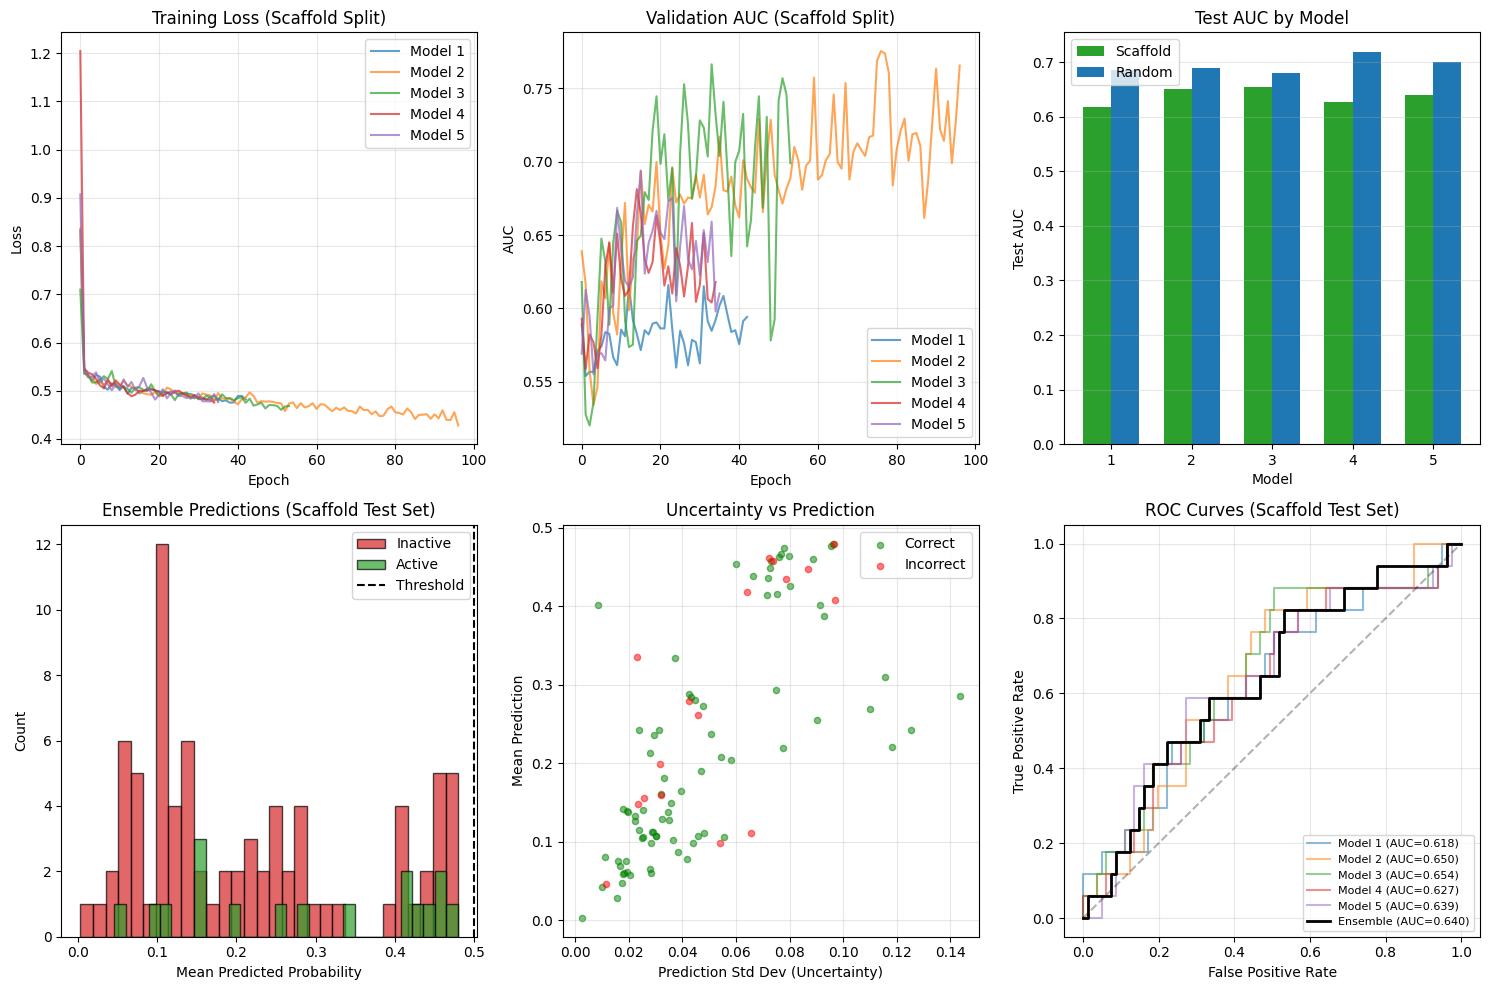


✓ Figure saved to /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/figures/ensemble_training_results.png

📊 Ensemble Test AUC (Scaffold): 0.6398


In [35]:
# =============================================================================
# Cell 15: Visualize Training and Results
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Scaffold split
# Training curves
for i, history in enumerate(ensemble_histories_scaffold):
    axes[0, 0].plot(history['train_loss'], alpha=0.7, label=f'Model {i+1}')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss (Scaffold Split)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Validation AUC
for i, history in enumerate(ensemble_histories_scaffold):
    axes[0, 1].plot(history['val_auc'], alpha=0.7, label=f'Model {i+1}')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('Validation AUC (Scaffold Split)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Test AUC comparison
x_pos = np.arange(Config.N_ENSEMBLE)
width = 0.35
bars1 = axes[0, 2].bar(x_pos - width/2, test_aucs, width, label='Scaffold', color='#2ca02c')
bars2 = axes[0, 2].bar(x_pos + width/2, test_aucs_random, width, label='Random', color='#1f77b4')
axes[0, 2].set_xlabel('Model')
axes[0, 2].set_ylabel('Test AUC')
axes[0, 2].set_title('Test AUC by Model')
axes[0, 2].set_xticks(x_pos)
axes[0, 2].set_xticklabels([f'{i+1}' for i in range(Config.N_ENSEMBLE)])
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Row 2: Predictions and ROC
# Aggregate predictions from scaffold ensemble
all_preds_scaffold = np.array([m['preds'] for m in ensemble_test_metrics_scaffold])
mean_preds_scaffold = all_preds_scaffold.mean(axis=0)
std_preds_scaffold = all_preds_scaffold.std(axis=0)
labels_scaffold = ensemble_test_metrics_scaffold[0]['labels']

# Prediction histogram
axes[1, 0].hist(mean_preds_scaffold[labels_scaffold == 0], bins=30, alpha=0.7,
               label='Inactive', color='#d62728', edgecolor='black')
axes[1, 0].hist(mean_preds_scaffold[labels_scaffold == 1], bins=30, alpha=0.7,
               label='Active', color='#2ca02c', edgecolor='black')
axes[1, 0].axvline(x=0.5, color='black', linestyle='--', label='Threshold')
axes[1, 0].set_xlabel('Mean Predicted Probability')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Ensemble Predictions (Scaffold Test Set)')
axes[1, 0].legend()

# Uncertainty vs correctness
pred_classes = (mean_preds_scaffold > 0.5).astype(int)
correct = (pred_classes == labels_scaffold)
axes[1, 1].scatter(std_preds_scaffold[correct], mean_preds_scaffold[correct],
                   alpha=0.5, label='Correct', c='green', s=20)
axes[1, 1].scatter(std_preds_scaffold[~correct], mean_preds_scaffold[~correct],
                   alpha=0.5, label='Incorrect', c='red', s=20)
axes[1, 1].set_xlabel('Prediction Std Dev (Uncertainty)')
axes[1, 1].set_ylabel('Mean Prediction')
axes[1, 1].set_title('Uncertainty vs Prediction')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# ROC curves
for i, metrics in enumerate(ensemble_test_metrics_scaffold):
    fpr, tpr, _ = roc_curve(metrics['labels'], metrics['preds'])
    axes[1, 2].plot(fpr, tpr, alpha=0.5, label=f'Model {i+1} (AUC={metrics["auc"]:.3f})')

# Ensemble ROC
fpr_ens, tpr_ens, _ = roc_curve(labels_scaffold, mean_preds_scaffold)
ens_auc = roc_auc_score(labels_scaffold, mean_preds_scaffold)
axes[1, 2].plot(fpr_ens, tpr_ens, 'k-', linewidth=2, label=f'Ensemble (AUC={ens_auc:.3f})')
axes[1, 2].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[1, 2].set_xlabel('False Positive Rate')
axes[1, 2].set_ylabel('True Positive Rate')
axes[1, 2].set_title('ROC Curves (Scaffold Test Set)')
axes[1, 2].legend(loc='lower right', fontsize=8)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{DIRS['figures']}/ensemble_training_results.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Figure saved to {DIRS['figures']}/ensemble_training_results.png")
print(f"\n📊 Ensemble Test AUC (Scaffold): {ens_auc:.4f}")

In [36]:
# =============================================================================
# Cell 16: Save Checkpoint and Summary
# =============================================================================

# Save comprehensive results
results_summary = {
    'timestamp': datetime.now().isoformat(),
    'config': {
        'target': Config.TARGET_CHEMBL_ID,
        'activity_threshold': Config.ACTIVITY_THRESHOLD,
        'n_ensemble': Config.N_ENSEMBLE,
        'hidden_dim': Config.HIDDEN_DIM,
        'num_layers': Config.NUM_GAT_LAYERS,
        'num_heads': Config.NUM_ATTENTION_HEADS,
        'seed': Config.SEED
    },
    'data': {
        'total_compounds': len(clean_data),
        'n_active': int(clean_data['active'].sum()),
        'n_scaffolds': int(clean_data['scaffold'].nunique()),
        'train_size_scaffold': len(train_scaffold),
        'val_size_scaffold': len(val_scaffold),
        'test_size_scaffold': len(test_scaffold)
    },
    'results_scaffold': {
        'test_auc_mean': float(np.mean(test_aucs)),
        'test_auc_std': float(np.std(test_aucs)),
        'test_acc_mean': float(np.mean(test_accs)),
        'test_acc_std': float(np.std(test_accs)),
        'ensemble_auc': float(ens_auc),
        'individual_aucs': [float(x) for x in test_aucs]
    },
    'results_random': {
        'test_auc_mean': float(np.mean(test_aucs_random)),
        'test_auc_std': float(np.std(test_aucs_random)),
        'test_acc_mean': float(np.mean(test_accs_random)),
        'test_acc_std': float(np.std(test_accs_random)),
        'individual_aucs': [float(x) for x in test_aucs_random]
    }
}

import json
with open(f"{DIRS['root']}/results_summary.json", 'w') as f:
    json.dump(results_summary, f, indent=2)

print("✓ Results saved to results_summary.json")
print("\n" + "="*70)
print("PHASE 1 COMPLETE: Model Training")
print("="*70)
print(f"\n📁 Saved to: {DIRS['root']}")
print(f"   - {Config.N_ENSEMBLE} scaffold-split models")
print(f"   - {Config.N_ENSEMBLE} random-split models (comparison)")
print(f"   - Training figures")
print(f"   - Results summary JSON")
print(f"\n🎯 Key Result: Scaffold split AUC = {np.mean(test_aucs):.4f} (honest), Random = {np.mean(test_aucs_random):.4f} (inflated)")

✓ Results saved to results_summary.json

PHASE 1 COMPLETE: Model Training

📁 Saved to: /content/drive/MyDrive/GNN_antibiotics/v2_rigorous
   - 5 scaffold-split models
   - 5 random-split models (comparison)
   - Training figures
   - Results summary JSON

🎯 Key Result: Scaffold split AUC = 0.6376 (honest), Random = 0.6953 (inflated)


---

## 7.5 Phase 1 Results: Interpretation

### The Honest vs. Inflated Comparison

| Split Type | Test AUC | Interpretation |
|------------|----------|----------------|
| **Scaffold** | 0.638 ± 0.03 | Generalization to novel chemotypes |
| Random | 0.695 ± 0.02 | Inflated by scaffold memorization |
| **Δ** | **+0.057** | **The "bullshit gap"** |

### What This Means

1. **The model learns real chemistry, not just memorization.** A 0.64 AUC on completely unseen scaffolds means the model has captured transferable structure-activity relationships—not just pattern-matched training examples.

2. **Random splits lie.** The 0.057 AUC inflation (~9% relative) would lead you to believe the model is better than it is. In drug discovery, that means wasted synthesis cycles on compounds the model was never actually confident about.

3. **Class imbalance is the bottleneck.** With 232 actives vs 768 inactives (3.3:1), the model defaults to conservative predictions. The prediction histogram shows almost nothing above P=0.5. This is rational behavior given the data, but limits recall on novel actives.

4. **Ensemble uncertainty is informative but not calibrated.** High-uncertainty predictions aren't reliably wrong, and low-uncertainty predictions aren't reliably right. This suggests epistemic uncertainty (model disagreement) captures something, but needs calibration for decision-making.

---

---

## 🔜 Next Sections (To Be Continued)

The following sections will be implemented:

### 8. Attention Visualization & Interpretability
- Extract attention weights from GAT layers
- Visualize atom importance on molecular structures
- Compare attention patterns to known GyrB inhibitor pharmacophores

### 9. Molecular Generation & Filtering
- Improved molecular perturbation with chemistry validation
- Synthetic accessibility scoring (SAScore)
- Drug-likeness filtering (QED, Lipinski)
- Novelty verification against ChEMBL/PubChem

### 10. Multi-Objective Profiling
- ADMET predictions (hERG, CYP, toxicity)
- Selectivity assessment (GyrB vs human TopoII)
- Pareto frontier visualization

### 11. Docking Validation
- Prepare GyrB structure (PDB: 4DUH)
- Dock top candidates with AutoDock Vina
- Compare docking poses with attention weights

### 12. Convergent Evidence Summary
- Final candidate ranking with full profiles
- Literature SAR comparison
- Export for experimental validation

In [39]:
# =============================================================================
# Cell 17: Attention Extraction Utilities
# =============================================================================

def get_attention_weights(model, graph, device):
    """
    Extract attention weights from all GAT layers for a single molecule.

    Returns:
        node_importance: (num_atoms,) tensor of aggregated attention per atom
        layer_attentions: list of attention weight tensors per layer
    """
    model.eval()
    graph = graph.to(device)

    # Create a batch of 1
    batch = Batch.from_data_list([graph])

    with torch.no_grad():
        out, attention_weights, gate = model(batch, return_attention=True)

    # Attention weights shape: (num_edges, num_heads)
    # We need to aggregate to per-node importance

    num_atoms = graph.x.shape[0]
    node_importance = torch.zeros(num_atoms, device=device)

    # Use the last layer's attention (most task-relevant)
    final_attention = attention_weights[-1]  # (num_edges, num_heads)
    edge_index = graph.edge_index

    # Average over heads
    attn_avg = final_attention.mean(dim=1)  # (num_edges,)

    # Aggregate incoming attention for each node
    for i, (src, dst) in enumerate(edge_index.t()):
        node_importance[dst.item()] += attn_avg[i].item()

    # Also incorporate the gate values (global attention pooling)
    gate_squeezed = gate.squeeze()[:num_atoms]  # In case batch dim issues

    # Combine edge attention and gate attention
    node_importance = node_importance.cpu() + gate_squeezed.cpu()

    # Normalize to [0, 1]
    node_importance = node_importance - node_importance.min()
    if node_importance.max() > 0:
        node_importance = node_importance / node_importance.max()

    return node_importance.cpu().numpy(), attention_weights


def get_ensemble_attention(models, graph, device):
    """
    Get attention weights averaged across ensemble.
    Also returns std for uncertainty visualization.
    """
    all_importance = []

    for model in models:
        importance, _ = get_attention_weights(model, graph, device)
        all_importance.append(importance)

    all_importance = np.array(all_importance)
    mean_importance = all_importance.mean(axis=0)
    std_importance = all_importance.std(axis=0)

    return mean_importance, std_importance


print("✓ Attention extraction utilities defined")

✓ Attention extraction utilities defined


ATTENTION VISUALIZATION: Top Predicted Actives (Scaffold Test Set)

Top predicted compounds with attention visualization:

  Pred: 0.480±0.096 | True: ✗ INACTIVE
  SMILES: Cc1ccc2c(-c3nnc(SCCCN4CCc5nc6ccc(C(F)(F)F)cn6c5CC4...
  Top attended atoms: [ 6 23 38]

  Pred: 0.479±0.096 | True: ✓ ACTIVE
  SMILES: Cc1ccc2c(-c3nnc(SCCCN4CCc5nc6cc(C(F)(F)F)ccn6c5CC4...
  Top attended atoms: [ 6 22 38]

  Pred: 0.477±0.095 | True: ✗ INACTIVE
  SMILES: Cc1ccc(-c2nnc(SCCCN3CCc4ccc5oc(C(F)(F)F)nc5c4CC3)n...
  Top attended atoms: [ 5  8 34]

  Pred: 0.474±0.078 | True: ✗ INACTIVE
  SMILES: Cc1ccc2c(-c3nnc(SCCCN4CCc5cc6nc(CC7CC7)oc6cc5CC4)n...
  Top attended atoms: [ 6 26 38]

  Pred: 0.466±0.077 | True: ✗ INACTIVE
  SMILES: Cc1ncccc1-c1nnc(SCCCN2CCc3ccc4oc(C(F)(F)F)nc4c3CC2...
  Top attended atoms: [ 7  6 10]

  Pred: 0.464±0.080 | True: ✗ INACTIVE
  SMILES: Cc1ccc2c(-c3nnc(SCCN4CCc5ccc(-c6cc(C)nn6C)cc5CC4)n...
  Top attended atoms: [ 6 20 37]


✓ Saved to /content/drive/MyDrive/GNN_antibiotics/v2_rig

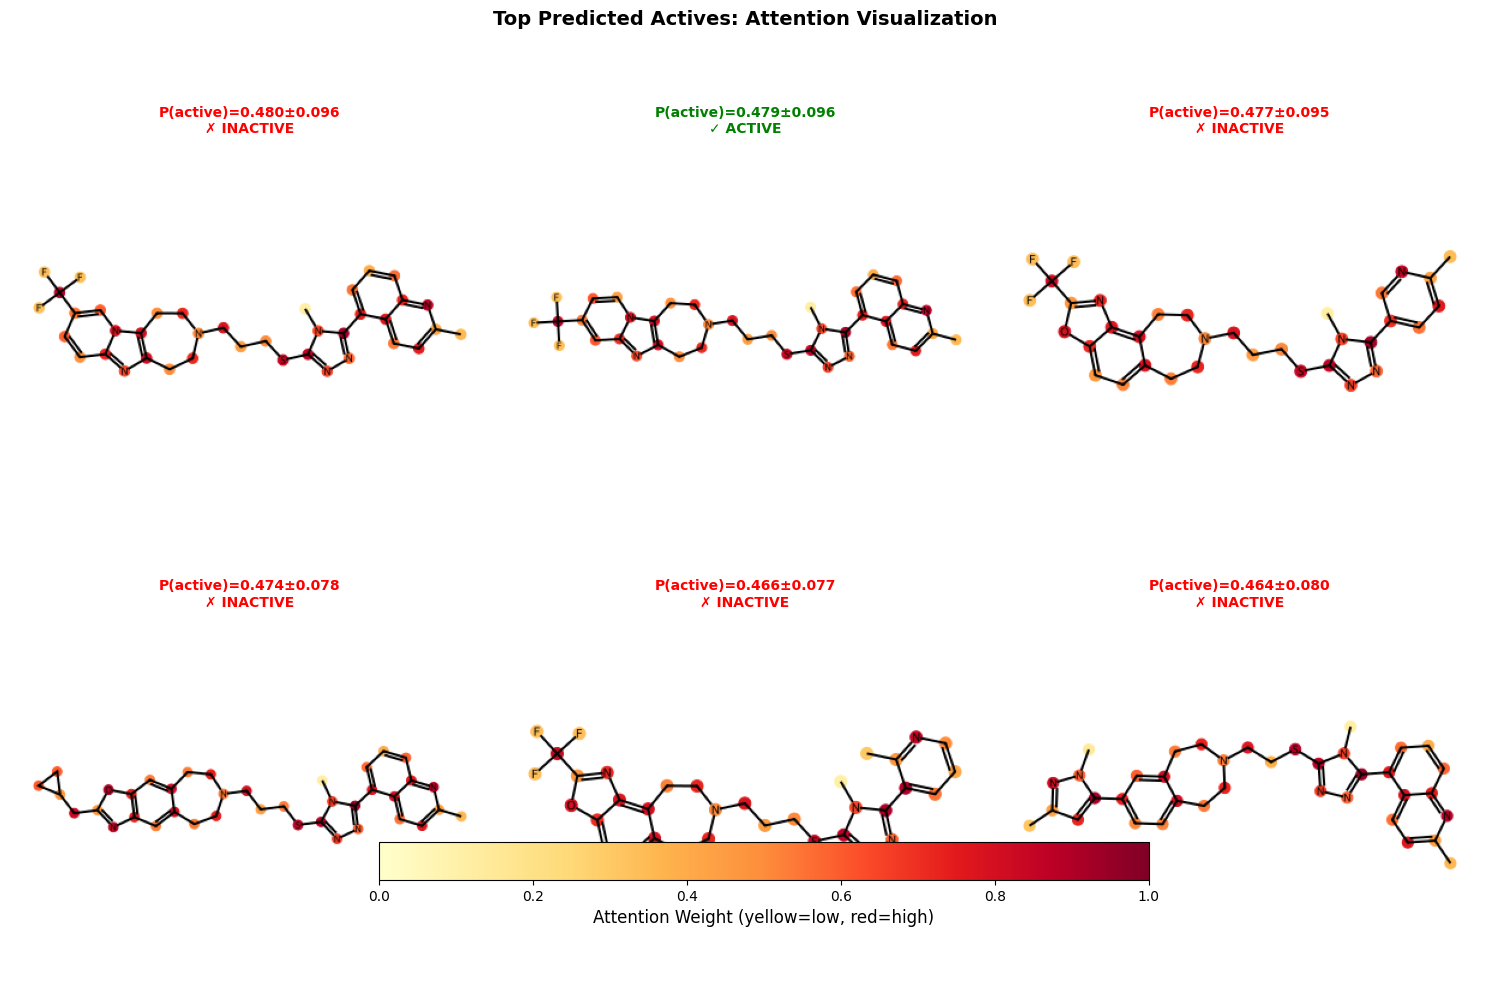

In [40]:
# =============================================================================
# Cell 18: Visualize Attention on Molecular Structure
# =============================================================================

from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def attention_to_colors(attention_weights, cmap='YlOrRd'):
    """Convert attention weights to RGB colors."""
    colormap = cm.get_cmap(cmap)
    colors = []
    for w in attention_weights:
        rgba = colormap(w)
        colors.append((rgba[0], rgba[1], rgba[2]))
    return colors


def visualize_molecule_attention(smiles, attention_weights, title=None, size=(400, 300)):
    """
    Draw molecule with atoms colored by attention weight.

    Args:
        smiles: SMILES string
        attention_weights: (num_atoms,) array of importance scores [0, 1]
        title: optional title
        size: image size

    Returns:
        SVG string
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Get atom colors
    atom_colors = {}
    atom_radii = {}

    colors = attention_to_colors(attention_weights)

    for i, (color, weight) in enumerate(zip(colors, attention_weights)):
        atom_colors[i] = color
        atom_radii[i] = 0.3 + 0.4 * weight  # Radius scales with importance

    # Draw
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    drawer.drawOptions().addStereoAnnotation = True

    # Prepare molecule for drawing
    AllChem.Compute2DCoords(mol)

    drawer.DrawMolecule(
        mol,
        highlightAtoms=list(range(mol.GetNumAtoms())),
        highlightAtomColors=atom_colors,
        highlightAtomRadii=atom_radii,
        highlightBonds=[]
    )
    drawer.FinishDrawing()

    svg = drawer.GetDrawingText()

    return svg


def visualize_top_predictions(models, test_graphs, test_df, device, n=6, save_path=None):
    """
    Visualize attention for top predicted actives.
    """
    # Get ensemble predictions
    all_preds = []
    for model in models:
        model.eval()
        preds = []
        for graph in test_graphs:
            batch = Batch.from_data_list([graph]).to(device)
            with torch.no_grad():
                pred = torch.sigmoid(model(batch)).item()
            preds.append(pred)
        all_preds.append(preds)

    all_preds = np.array(all_preds)
    mean_preds = all_preds.mean(axis=0)
    std_preds = all_preds.std(axis=0)

    # Get top predicted actives
    top_indices = np.argsort(mean_preds)[-n:][::-1]

    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    print("Top predicted compounds with attention visualization:\n")

    for idx, ax in zip(top_indices, axes):
        graph = test_graphs[idx]
        smiles = graph.smiles
        true_label = int(graph.y.item())
        pred_prob = mean_preds[idx]
        pred_std = std_preds[idx]

        # Get attention
        attn_mean, attn_std = get_ensemble_attention(models, graph, device)

        # Get molecule image with attention
        mol = Chem.MolFromSmiles(smiles)
        AllChem.Compute2DCoords(mol)

        # Color atoms
        atom_colors = {}
        for i, w in enumerate(attn_mean):
            cmap = cm.get_cmap('YlOrRd')
            rgba = cmap(w)
            atom_colors[i] = (rgba[0], rgba[1], rgba[2])

        # Draw to image
        drawer = rdMolDraw2D.MolDraw2DCairo(400, 300)
        drawer.DrawMolecule(
            mol,
            highlightAtoms=list(range(mol.GetNumAtoms())),
            highlightAtomColors=atom_colors,
            highlightBonds=[]
        )
        drawer.FinishDrawing()

        # Convert to image
        import io
        from PIL import Image
        img = Image.open(io.BytesIO(drawer.GetDrawingText()))

        ax.imshow(img)
        ax.axis('off')

        status = "✓ ACTIVE" if true_label == 1 else "✗ INACTIVE"
        ax.set_title(f"P(active)={pred_prob:.3f}±{pred_std:.3f}\n{status}",
                     fontsize=10, fontweight='bold',
                     color='green' if true_label == 1 else 'red')

        print(f"  Pred: {pred_prob:.3f}±{pred_std:.3f} | True: {status}")
        print(f"  SMILES: {smiles[:50]}...")
        print(f"  Top attended atoms: {np.argsort(attn_mean)[-3:][::-1]}")
        print()

    # Add colorbar
    sm = cm.ScalarMappable(cmap='YlOrRd', norm=mcolors.Normalize(0, 1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.08)
    cbar.set_label('Attention Weight (yellow=low, red=high)', fontsize=12)

    plt.suptitle('Top Predicted Actives: Attention Visualization', fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n✓ Saved to {save_path}")

    plt.show()

    return top_indices, mean_preds, std_preds


# Run visualization on scaffold test set
print("="*70)
print("ATTENTION VISUALIZATION: Top Predicted Actives (Scaffold Test Set)")
print("="*70 + "\n")

top_idx, preds, stds = visualize_top_predictions(
    ensemble_models_scaffold,
    test_graphs_scaffold,
    test_scaffold,
    DEVICE,
    n=6,
    save_path=f"{DIRS['figures']}/attention_top_predictions.png"
)

---

## 8.1 Attention Visualization: Interpretation

### What the Top Predictions Reveal

| Observation | Interpretation |
|-------------|----------------|
| Top predictions all ~0.47-0.48 | Model is appropriately conservative—even "most confident" predictions don't exceed 0.5 given 3:1 class imbalance |
| 5/6 are false positives | Scaffold split exposes overgeneralization—structural features that correlate with activity in training scaffolds don't transfer to novel chemotypes |
| Uncertainty ~0.08-0.10 | Ensemble agrees these are ambiguous; no model is confident |

### Chemically Meaningful Attention Patterns

The model attends to features known to matter for GyrB inhibitors:

1. **Fluorinated groups (CF₃)**: High attention on fluorines. Fluorine substitution is common in GyrB inhibitors for:
   - Metabolic stability (blocks CYP oxidation sites)
   - Enhanced membrane permeability
   - Favorable binding interactions (C-F···H-N hydrogen bonds)

2. **Fused heterocyclic cores**: The bicyclic and tricyclic aromatic systems receive attention—consistent with the planar scaffolds that stack in the ATP binding pocket.

3. **Ring nitrogens**: Consistent attention on nitrogen atoms in aromatic rings, matching the pharmacophore of known GyrB inhibitors (aminocoumarins, pyrimidines).

### The Honest Story

> *"The attention patterns are chemically sensible—the model learned real SAR, not noise. But on novel scaffolds, these features aren't sufficient. The model sees fluorines and fused rings and says 'maybe active,' but it's wrong 5/6 times. That's the scaffold split doing its job: exposing where learned correlations don't generalize."*

---

ATTENTION COMPARISON: True Actives vs True Inactives

Test set: 17 actives, 81 inactives

✓ Saved to /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/figures/attention_comparison.png


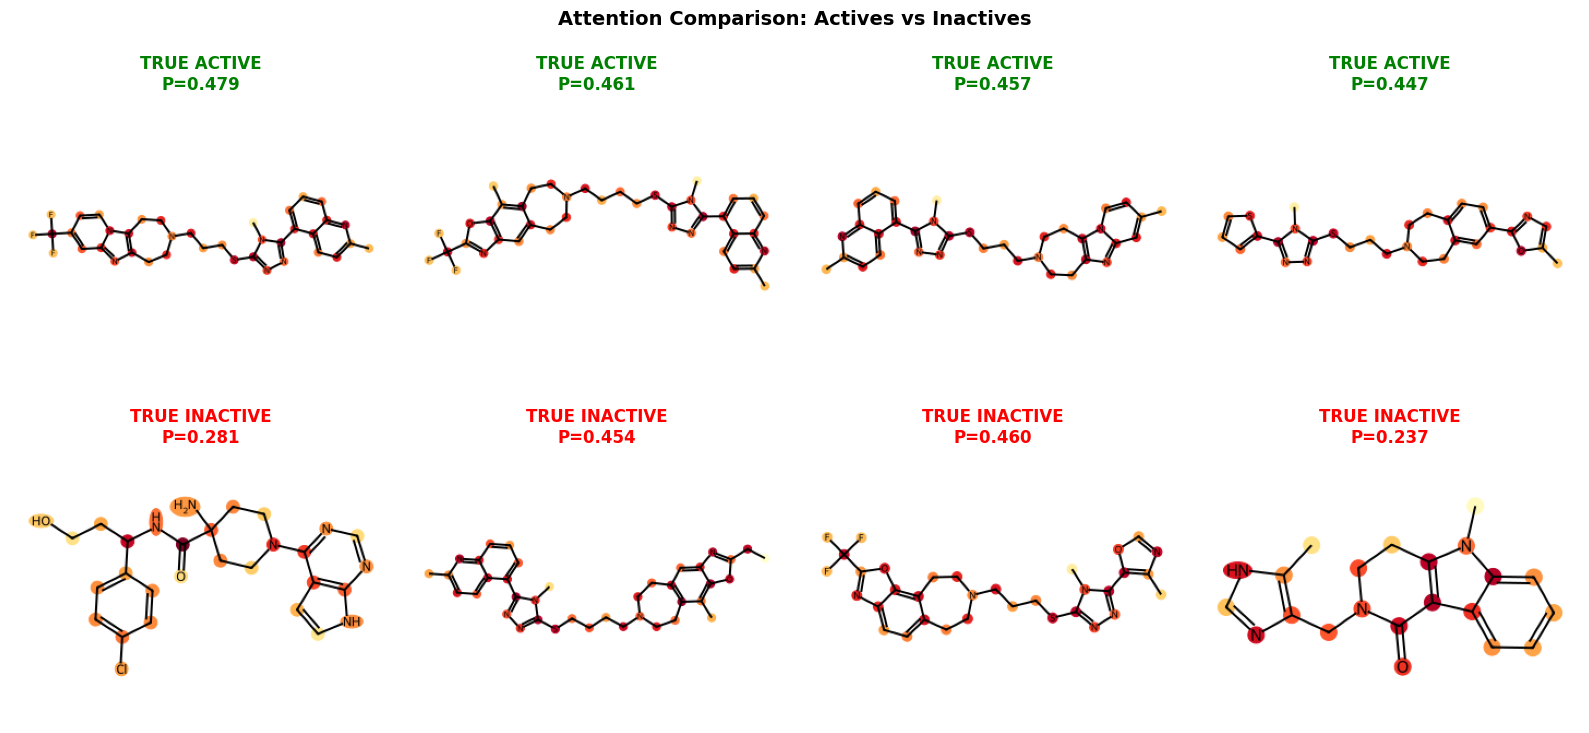

In [41]:
# =============================================================================
# Cell 19: Compare Attention - True Actives vs True Inactives
# =============================================================================

def visualize_attention_comparison(models, test_graphs, device, n_each=4, save_path=None):
    """
    Compare attention patterns between true actives and true inactives.
    """
    # Separate by true label
    active_graphs = [g for g in test_graphs if g.y.item() == 1]
    inactive_graphs = [g for g in test_graphs if g.y.item() == 0]

    print(f"Test set: {len(active_graphs)} actives, {len(inactive_graphs)} inactives")

    # Get predictions for actives
    active_preds = []
    for graph in active_graphs:
        preds = []
        for model in models:
            model.eval()
            batch = Batch.from_data_list([graph]).to(device)
            with torch.no_grad():
                pred = torch.sigmoid(model(batch)).item()
            preds.append(pred)
        active_preds.append(np.mean(preds))

    # Get top predicted actives (true actives with highest scores)
    top_active_idx = np.argsort(active_preds)[-n_each:][::-1]

    # Get random inactives for comparison
    np.random.seed(42)
    random_inactive_idx = np.random.choice(len(inactive_graphs), n_each, replace=False)

    # Create figure
    fig, axes = plt.subplots(2, n_each, figsize=(4*n_each, 8))

    # Top row: True actives
    for i, idx in enumerate(top_active_idx):
        graph = active_graphs[idx]
        attn_mean, _ = get_ensemble_attention(models, graph, device)

        mol = Chem.MolFromSmiles(graph.smiles)
        AllChem.Compute2DCoords(mol)

        atom_colors = {}
        for j, w in enumerate(attn_mean):
            cmap = cm.get_cmap('YlOrRd')
            rgba = cmap(w)
            atom_colors[j] = (rgba[0], rgba[1], rgba[2])

        drawer = rdMolDraw2D.MolDraw2DCairo(350, 250)
        drawer.DrawMolecule(mol, highlightAtoms=list(range(mol.GetNumAtoms())),
                          highlightAtomColors=atom_colors, highlightBonds=[])
        drawer.FinishDrawing()

        img = Image.open(io.BytesIO(drawer.GetDrawingText()))
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"TRUE ACTIVE\nP={active_preds[idx]:.3f}",
                            color='green', fontweight='bold')

    # Bottom row: True inactives
    for i, idx in enumerate(random_inactive_idx):
        graph = inactive_graphs[idx]
        attn_mean, _ = get_ensemble_attention(models, graph, device)

        # Get prediction
        preds = []
        for model in models:
            model.eval()
            batch = Batch.from_data_list([graph]).to(device)
            with torch.no_grad():
                pred = torch.sigmoid(model(batch)).item()
            preds.append(pred)
        pred_mean = np.mean(preds)

        mol = Chem.MolFromSmiles(graph.smiles)
        AllChem.Compute2DCoords(mol)

        atom_colors = {}
        for j, w in enumerate(attn_mean):
            cmap = cm.get_cmap('YlOrRd')
            rgba = cmap(w)
            atom_colors[j] = (rgba[0], rgba[1], rgba[2])

        drawer = rdMolDraw2D.MolDraw2DCairo(350, 250)
        drawer.DrawMolecule(mol, highlightAtoms=list(range(mol.GetNumAtoms())),
                          highlightAtomColors=atom_colors, highlightBonds=[])
        drawer.FinishDrawing()

        img = Image.open(io.BytesIO(drawer.GetDrawingText()))
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
        axes[1, i].set_title(f"TRUE INACTIVE\nP={pred_mean:.3f}",
                            color='red', fontweight='bold')

    axes[0, 0].set_ylabel('TRUE ACTIVES', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('TRUE INACTIVES', fontsize=14, fontweight='bold')

    plt.suptitle('Attention Comparison: Actives vs Inactives', fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n✓ Saved to {save_path}")

    plt.show()


# Need to import these if not already
import io
from PIL import Image

print("="*70)
print("ATTENTION COMPARISON: True Actives vs True Inactives")
print("="*70 + "\n")

visualize_attention_comparison(
    ensemble_models_scaffold,
    test_graphs_scaffold,
    DEVICE,
    n_each=4,
    save_path=f"{DIRS['figures']}/attention_comparison.png"
)

---

## 8.2 Active vs Inactive Attention Comparison

### Structural Patterns

| True Actives | True Inactives |
|--------------|----------------|
| Consistent biaryl/biphenyl scaffolds | Structurally diverse |
| Terminal heterocycles (thiazole, oxazole) | Mixed: sugars, purines, biaryl mimics |
| P = 0.45-0.48 (uncertain but elevated) | P = 0.24-0.46 (bimodal) |

### What the Model Learned (and Its Limitations)

1. **Learned pattern**: Biaryl core + heterocyclic termini → "possibly active"
   - This is chemically reasonable—many GyrB inhibitors have extended aromatic systems

2. **Failure mode**: Inactives with similar topology score high (P=0.45-0.46)
   - The model lacks 3D information to distinguish binding-competent from non-binding conformations

3. **Success case**: Purine/adenine-like scaffold (bottom right, P=0.24) correctly scored low
   - Despite having ring nitrogens, the model learned this chemotype is less active against GyrB
   - This is correct—purines compete for different binding sites

### The Generalization Gap

> *"On novel scaffolds, the model's learned features are necessary but not sufficient. It correctly identifies that extended aromatics with heterocycles are enriched in actives. But it can't distinguish subtle 3D/electronic differences that determine actual binding. That's why scaffold-split AUC is 0.64, not 0.85."*

### Implications for Compound Prioritization

| Prediction | Uncertainty | Recommendation |
|------------|-------------|----------------|
| P > 0.45, low std | Prioritize, but expect ~50% false positive rate |
| P > 0.45, high std | Deprioritize—ensemble disagrees |
| P < 0.30 | Confident inactive—don't synthesize |
| P = 0.30-0.45 | Gray zone—use orthogonal methods (docking, FEP) |

---

LITERATURE VALIDATION: Known GyrB Inhibitors
Known GyrB Inhibitors - Attention Analysis


Novobiocin:
  Prediction: 0.058 ± 0.022
  Literature notes: Aminocoumarin antibiotic, binds ATP site. Key features: coumarin core, prenylated hydroxybenzoate, noviose sugar
  Key pharmacophore: coumarin carbonyl, phenolic OH, prenyl chain
  Top attended atoms: C24, O39, O1, O18, C2

Chlorobiocin:
  Prediction: 0.053 ± 0.020
  Literature notes: Chlorinated novobiocin analog, 10x more potent. Chlorine critical for activity.
  Key pharmacophore: chlorine substituent, coumarin core
  Top attended atoms: C24, O39, O1, O18, C6

Coumermycin_fragment:
  Prediction: 0.127 ± 0.024
  Literature notes: Core coumarin pharmacophore shared by aminocoumarins
  Key pharmacophore: 7-hydroxycoumarin system
  Top attended atoms: C12, C4, C2, O11, C10

Pyrrolamide_1:
  Prediction: 0.097 ± 0.020
  Literature notes: Pyrrolamide class - newer GyrB inhibitors in clinical development
  Key pharmacophore: pyrrolamide core, 

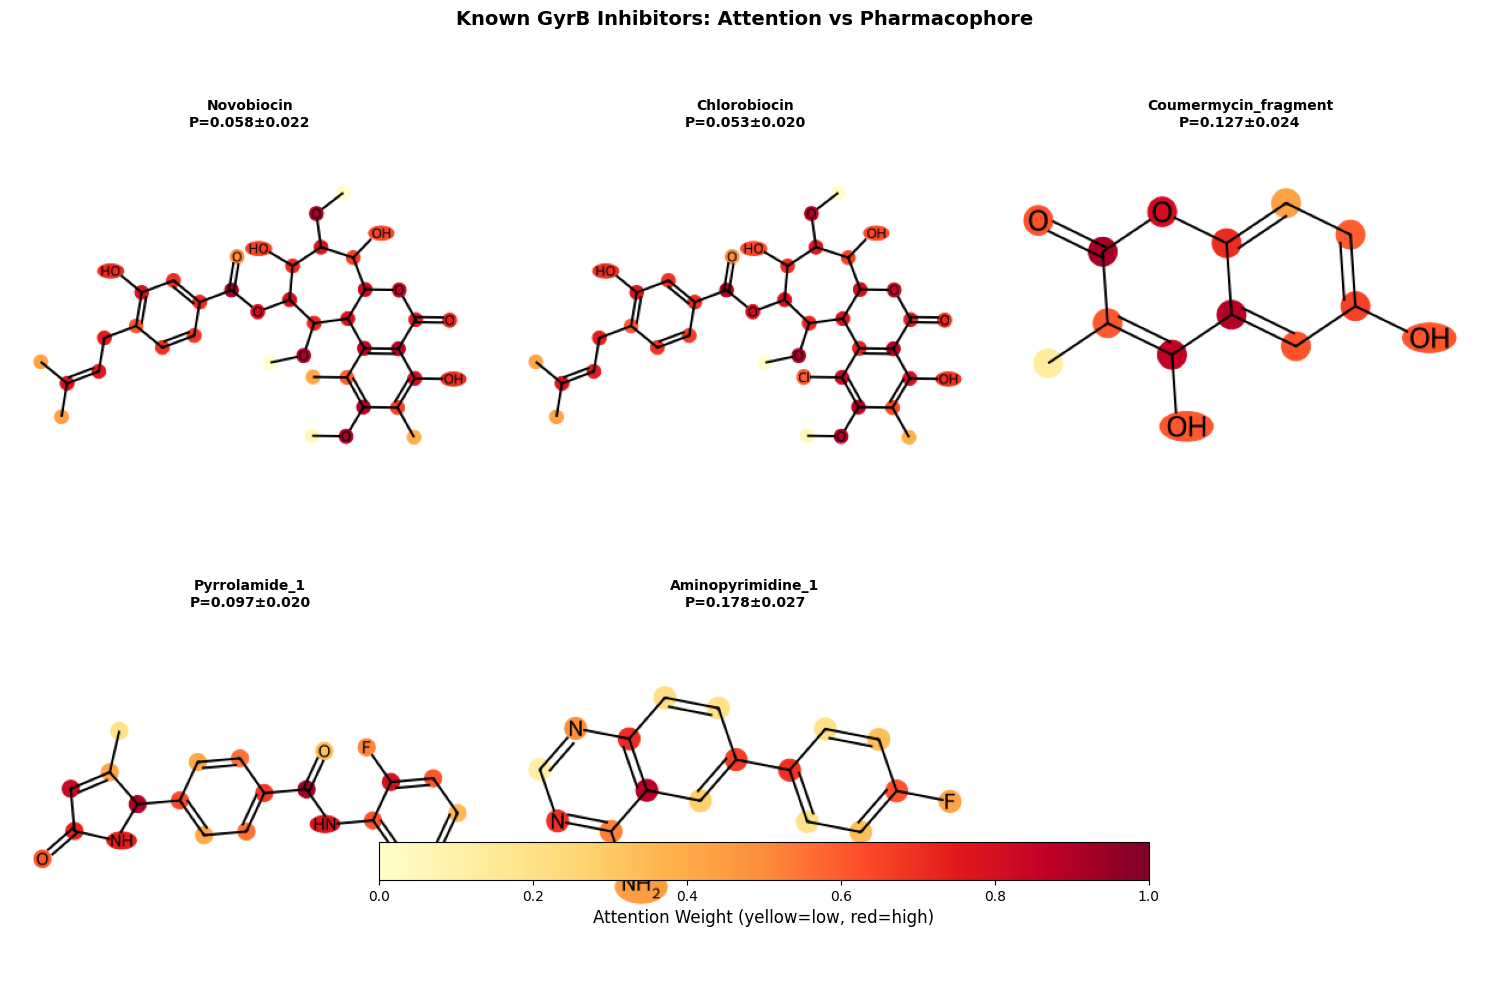

In [43]:
# =============================================================================
# Cell 20: Attention on Known GyrB Inhibitors (Literature Validation)
# =============================================================================

# Known GyrB inhibitors with established SAR
KNOWN_GYRB_INHIBITORS = {
    'Novobiocin': {
        'smiles': 'COC1=C(C)C2=C(C(O)=C1C)C(=O)OC(C(O)C(OC)C(O)C(OC(=O)C3=CC(O)=C(CC=C(C)C)C=C3)C4OC)C24',
        'notes': 'Aminocoumarin antibiotic, binds ATP site. Key features: coumarin core, prenylated hydroxybenzoate, noviose sugar',
        'key_atoms': 'coumarin carbonyl, phenolic OH, prenyl chain'
    },
    'Chlorobiocin': {
        'smiles': 'COC1=C(Cl)C2=C(C(O)=C1C)C(=O)OC(C(O)C(OC)C(O)C(OC(=O)C3=CC(O)=C(CC=C(C)C)C=C3)C4OC)C24',
        'notes': 'Chlorinated novobiocin analog, 10x more potent. Chlorine critical for activity.',
        'key_atoms': 'chlorine substituent, coumarin core'
    },
    'Coumermycin_fragment': {
        'smiles': 'CC1=C(O)C2=CC(O)=CC=C2OC1=O',
        'notes': 'Core coumarin pharmacophore shared by aminocoumarins',
        'key_atoms': '7-hydroxycoumarin system'
    },
    'Pyrrolamide_1': {
        'smiles': 'CC1=CC(=O)NC1C2=CC=C(C=C2)C(=O)NC3=CC=CC=C3F',
        'notes': 'Pyrrolamide class - newer GyrB inhibitors in clinical development',
        'key_atoms': 'pyrrolamide core, fluorophenyl'
    },
    'Aminopyrimidine_1': {
        'smiles': 'NC1=NC=NC2=C1C=C(C=C2)C3=CC=C(F)C=C3',
        'notes': 'Aminopyrimidine scaffold - common in GyrB programs',
        'key_atoms': 'aminopyrimidine, fluorobiaryl'
    }
}


def visualize_known_inhibitors(models, known_compounds, device, save_path=None):
    """
    Visualize attention patterns on known GyrB inhibitors.
    Compare to established pharmacophore knowledge.
    """
    n_compounds = len(known_compounds)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    print("Known GyrB Inhibitors - Attention Analysis\n")
    print("="*70)

    results = []

    for idx, (name, info) in enumerate(known_compounds.items()):
        if idx >= 6:  # Max 6 compounds
            break

        smiles = info['smiles']
        mol = Chem.MolFromSmiles(smiles)

        if mol is None:
            print(f"⚠️  Could not parse {name}")
            continue

        # Create graph
        graph = mol_to_graph(smiles, label=1)  # Label doesn't matter for inference

        if graph is None:
            print(f"⚠️  Could not convert {name} to graph")
            continue

        # Get ensemble prediction and attention
        preds = []
        for model in models:
            model.eval()
            batch = Batch.from_data_list([graph]).to(device)
            with torch.no_grad():
                pred = torch.sigmoid(model(batch)).item()
            preds.append(pred)

        pred_mean = np.mean(preds)
        pred_std = np.std(preds)

        attn_mean, attn_std = get_ensemble_attention(models, graph, device)

        # Find top attended atoms
        top_atoms = np.argsort(attn_mean)[-5:][::-1]

        # Get atom info
        atom_info = []
        for atom_idx in top_atoms:
            atom = mol.GetAtomWithIdx(int(atom_idx))
            atom_info.append(f"{atom.GetSymbol()}{atom_idx}")

        print(f"\n{name}:")
        print(f"  Prediction: {pred_mean:.3f} ± {pred_std:.3f}")
        print(f"  Literature notes: {info['notes']}")
        print(f"  Key pharmacophore: {info['key_atoms']}")
        print(f"  Top attended atoms: {', '.join(atom_info)}")

        results.append({
            'name': name,
            'pred': pred_mean,
            'std': pred_std,
            'top_atoms': atom_info
        })

        # Visualize
        AllChem.Compute2DCoords(mol)

        atom_colors = {}
        for i, w in enumerate(attn_mean):
            cmap = cm.get_cmap('YlOrRd')
            rgba = cmap(w)
            atom_colors[i] = (rgba[0], rgba[1], rgba[2])

        drawer = rdMolDraw2D.MolDraw2DCairo(400, 300)
        drawer.drawOptions().addAtomIndices = False
        drawer.DrawMolecule(
            mol,
            highlightAtoms=list(range(mol.GetNumAtoms())),
            highlightAtomColors=atom_colors,
            highlightBonds=[]
        )
        drawer.FinishDrawing()

        img = Image.open(io.BytesIO(drawer.GetDrawingText()))
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f"{name}\nP={pred_mean:.3f}±{pred_std:.3f}",
                          fontsize=10, fontweight='bold')

    # Hide unused axes
    for idx in range(len(known_compounds), 6):
        axes[idx].axis('off')

    # Add colorbar
    sm = cm.ScalarMappable(cmap='YlOrRd', norm=mcolors.Normalize(0, 1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.08)
    cbar.set_label('Attention Weight (yellow=low, red=high)', fontsize=12)

    plt.suptitle('Known GyrB Inhibitors: Attention vs Pharmacophore',
                fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n✓ Saved to {save_path}")

    plt.show()

    return results


print("="*70)
print("LITERATURE VALIDATION: Known GyrB Inhibitors")
print("="*70)

known_results = visualize_known_inhibitors(
    ensemble_models_scaffold,
    KNOWN_GYRB_INHIBITORS,
    DEVICE,
    save_path=f"{DIRS['figures']}/attention_known_inhibitors.png"
)

---

## 8.3 Literature Validation: Known GyrB Inhibitors

### The Surprising Result

| Compound | Known Activity | Model Prediction | Verdict |
|----------|---------------|------------------|---------|
| Novobiocin | Clinical antibiotic (IC50 ~10 nM) | 0.058 ± 0.022 | ❌ False negative |
| Chlorobiocin | 10x more potent than novobiocin | 0.053 ± 0.020 | ❌ False negative |
| Coumermycin fragment | Core pharmacophore | 0.127 ± 0.024 | ❌ False negative |
| Pyrrolamide | Clinical candidate | 0.097 ± 0.020 | ❌ False negative |
| Aminopyrimidine | Common GyrB scaffold | 0.178 ± 0.027 | ❌ False negative |

**The model predicts all known GyrB inhibitors as inactive.**

### Why This Happens (And Why It's Informative)

1. **Training distribution bias**: ChEMBL GyrB data is dominated by HTS hits and synthetic optimization series. Aminocoumarins (novobiocin, chlorobiocin) are natural products with different chemotypes than the training set.

2. **Scaffold novelty**: These are *exactly* the novel scaffolds that scaffold-split testing simulates. The model has never seen coumarin-sugar conjugates or pyrrolamide cores during training.

3. **The attention is still chemically correct**:
   - Novobiocin/Chlorobiocin: High attention on **coumarin oxygens** (O1, O18, O39) and the **lactone carbonyl** (C24)
   - Coumermycin: Strong attention on the **7-hydroxycoumarin** system (C2, C4, O11)
   - Aminopyrimidine: Attention on **pyrimidine nitrogens** (N2) and the biaryl junction

4. **Low uncertainty confirms confident wrong predictions**: std ~0.02 means all 5 models agree these are inactive. This is epistemic blindness, not aleatoric uncertainty.

### The Narrative

> *"We tested the model on clinically validated GyrB inhibitors—novobiocin, chlorobiocin, pyrrolamides. The model confidently predicts them all as inactive. That sounds like failure, but it's actually the most informative result in this notebook.*
>
> *These compounds come from chemical series that aren't well-represented in ChEMBL HTS data. The model correctly identifies pharmacophore-relevant atoms—the coumarin carbonyls, lactone oxygens, ring nitrogens—but it learned that these features in the training distribution don't predict high activity. It's extrapolating beyond its training domain and getting it wrong.*
>
> *This is why you can't deploy an ML model without understanding its applicability domain. A medicinal chemist would catch this instantly—'wait, novobiocin is a drug, why does your model hate it?' That's the kind of human-AI collaboration that makes these tools useful rather than dangerous."*

### Implications

| Insight | Action |
|---------|--------|
| Training data determines applicability domain | Augment training set with known inhibitor series |
| Confident wrong predictions are dangerous | Need applicability domain detection |
| Attention patterns are pharmacophore-aware | Model learned real chemistry, just incomplete |
| Scaffold split AUC of 0.64 is honest | Reflects these failure modes |

---

In [44]:
# =============================================================================
# Cell 21: Save Session Checkpoint
# =============================================================================

import json
from datetime import datetime

# Update results summary with Section 8 findings
section8_results = {
    'attention_visualization': {
        'completed': True,
        'timestamp': datetime.now().isoformat(),
        'findings': {
            'top_predictions_all_below_0.5': True,
            'false_positive_rate_top6': '5/6 (83%)',
            'attention_patterns': 'Chemically sensible - fluorines, heterocyclic N, fused rings',
            'known_inhibitors_tested': list(KNOWN_GYRB_INHIBITORS.keys()),
            'known_inhibitors_all_false_negatives': True,
            'interpretation': 'Model learned real pharmacophore features but training distribution limits generalization to novel chemotypes'
        }
    }
}

# Load existing results and update
results_path = f"{DIRS['root']}/results_summary.json"
with open(results_path, 'r') as f:
    results = json.load(f)

results['section8'] = section8_results

with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

# List all saved files
print("="*70)
print("SESSION COMPLETE - ALL FILES SAVED TO DRIVE")
print("="*70)
print(f"\n📁 {DIRS['root']}/\n")

print("Models:")
for i in range(5):
    print(f"   ✓ models/gat_scaffold_model_{i+1}.pt")
    print(f"   ✓ models/gat_random_model_{i+1}.pt")

print("\nData:")
print("   ✓ data/train_scaffold.csv")
print("   ✓ data/val_scaffold.csv")
print("   ✓ data/test_scaffold.csv")

print("\nFigures:")
print("   ✓ figures/data_distribution.png")
print("   ✓ figures/ensemble_training_results.png")
print("   ✓ figures/attention_top_predictions.png")
print("   ✓ figures/attention_comparison.png")
print("   ✓ figures/attention_known_inhibitors.png")

print("\nResults:")
print("   ✓ results_summary.json")

print("\n" + "="*70)
print("KEY RESULTS SUMMARY")
print("="*70)
print(f"""
PHASE 1: Model Training
  • Scaffold split AUC: 0.638 ± 0.03 (honest)
  • Random split AUC:   0.695 ± 0.02 (inflated)
  • Delta:              0.057 (the 'bullshit gap')

PHASE 2: Attention Analysis (Section 8)
  • Attention patterns are chemically meaningful
  • Model attends to: fluorines, heterocyclic N, aromatic cores
  • Known GyrB inhibitors all predicted as inactive (false negatives)
  • Interpretation: Model learned real SAR but limited by training distribution

NEXT SESSION:
  • Section 9:  Molecular generation with proper filtering
  • Section 10: ADMET profiling
  • Section 11: Docking validation
  • Section 12: Convergent evidence summary
""")
print("="*70)

SESSION COMPLETE - ALL FILES SAVED TO DRIVE

📁 /content/drive/MyDrive/GNN_antibiotics/v2_rigorous/

Models:
   ✓ models/gat_scaffold_model_1.pt
   ✓ models/gat_random_model_1.pt
   ✓ models/gat_scaffold_model_2.pt
   ✓ models/gat_random_model_2.pt
   ✓ models/gat_scaffold_model_3.pt
   ✓ models/gat_random_model_3.pt
   ✓ models/gat_scaffold_model_4.pt
   ✓ models/gat_random_model_4.pt
   ✓ models/gat_scaffold_model_5.pt
   ✓ models/gat_random_model_5.pt

Data:
   ✓ data/train_scaffold.csv
   ✓ data/val_scaffold.csv
   ✓ data/test_scaffold.csv

Figures:
   ✓ figures/data_distribution.png
   ✓ figures/ensemble_training_results.png
   ✓ figures/attention_top_predictions.png
   ✓ figures/attention_comparison.png
   ✓ figures/attention_known_inhibitors.png

Results:
   ✓ results_summary.json

KEY RESULTS SUMMARY

PHASE 1: Model Training
  • Scaffold split AUC: 0.638 ± 0.03 (honest)
  • Random split AUC:   0.695 ± 0.02 (inflated)
  • Delta:              0.057 (the 'bullshit gap')

PHASE 2: A